# Biblioteca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta, date

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error

# sse = np.sum((model.fittedvalues - df.score)**2)

# Funcoes

In [2]:
def moving_average_test(series):
    serie = series.copy()

    error = pd.DataFrame(columns = ['n_window','RMSE'])

    for window in range(1, series.shape[0] -20):

        serie['media_movel_'+str(window)] = serie.Volume.rolling(window).mean()
        serie['media_movel_'+str(window)] = serie['media_movel_'+str(window)].fillna(0)

        # display(serie)

        error = pd.concat( [error ,
                            pd.DataFrame(   {   'n_window':window,
                                                'RMSE':mean_squared_error(serie.Volume,serie['media_movel_'+str(window)], squared = False)}, index= [0]
                                        )], ignore_index = True, axis = 0)

    return error


def moving_median_test(series):
    serie = series.copy()

    error = pd.DataFrame(columns = ['n_window','RMSE'])

    for window in range(1, series.shape[0] -20):

        serie['media_movel_'+str(window)] = serie.Volume.rolling(window).median()
        serie['media_movel_'+str(window)] = serie['media_movel_'+str(window)].fillna(0)

        # display(serie)

        error = pd.concat( [error ,
                            pd.DataFrame(   {   'n_window':window,
                                                'RMSE':mean_squared_error(serie.Volume,serie['media_movel_'+str(window)], squared = False)}, index= [0]
                                        )], ignore_index = True, axis = 0)

    return error

# Acessando arquivos


In [3]:
clusters = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/clusters_18medoids.xlsx')
dict_ = {}
for dic in range((clusters.shape[0])):
    # print(dic)
    dict_[clusters['clusters'][dic]] = clusters['medoids'][dic]
# dict_

In [4]:
# abrindo arquivos
viagens_validas = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/matriz_junho_mapeada.xlsx', index_col='Unnamed: 0')

# viagens_validas['dataInicio'] = pd.to_datetime(viagens_validas['dataInicio'])
# viagens_validas['dataFim'] = pd.to_datetime(viagens_validas['dataFim'])


#renomeia colunas
viagens_validas.columns = ['index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'latitudeI', 'longitudeI',
       'latitudeF', 'longitudeF', 'Nome_PontoI', 'Nome_PontoF', 'PontoFinal',
       'dist_PontoF', 'PontoInicial', 'dist_PontoI']

# reordena colunas
viagens_validas = viagens_validas[[  'index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'PontoInicial','Nome_PontoI','latitudeI', 'longitudeI','dist_PontoI',
       'PontoFinal','Nome_PontoF','latitudeF', 'longitudeF',  'dist_PontoF'  ]]

# ajusta numero do ponto ao dicionario de pontos 
viagens_validas['PontoInicial']    = viagens_validas['PontoInicial']    -1
viagens_validas['PontoFinal']      = viagens_validas['PontoFinal']      -1

viagens_validas['NEW_PontoInicial'] = viagens_validas['PontoInicial'].map(dict_)
viagens_validas['NEW_PontoFinal']   = viagens_validas['PontoFinal'].map(dict_)

viagens_validas['NEW_PontoInicial']  = viagens_validas['NEW_PontoInicial'].astype(int) 
viagens_validas['NEW_PontoFinal']    = viagens_validas['NEW_PontoFinal']  .astype(int) 

viagens_validas['day_of_week'] = viagens_validas.dataInicio.dt.day_of_week

# Volumes totais diarios

## Organizacao dos volumes por dia da serie (tirando 0)

In [5]:
start_date = date(2021,6,1)
end_date = date(2021,8,31)

volumes_totais_diarios = pd.DataFrame(columns = ['Volume'])

while start_date <= end_date:    
    volumes_totais_diarios = pd.concat([volumes_totais_diarios,
        
        pd.DataFrame(data= {'Volume':[viagens_validas.loc[viagens_validas['dataInicio'].dt.date == start_date].shape[0]]  })  ]  ,
                                                        axis = 0, ignore_index = True)
    start_date += timedelta(days=1)


volumes_totais_diarios.index = pd.date_range('2022-06-01', '2022-08-31')
volumes_totais_diarios.loc[:,'Volume'] = volumes_totais_diarios.loc[:,'Volume'].astype(int)

volumes_totais_diarios.reset_index(inplace=True)
volumes_totais_diarios.columns = ['Data', 'Volume']

## drop volumes vazios
volumes_totais_diarios = volumes_totais_diarios.loc[volumes_totais_diarios['Volume'] != 0].reset_index(drop=True)


volumes_totais_diarios


,Data,Volume
0,2022-06-01,139
1,2022-06-02,290
2,2022-06-07,241
3,2022-06-08,311
4,2022-06-09,291
...,...,...
59,2022-08-25,244
60,2022-08-26,290
61,2022-08-27,279
62,2022-08-30,221


In [ ]:
volumes_totais_diarios.Data.dt.month.value_counts().sort_index()

6    20
7    21
8    23
Name: Data, dtype: int64

### Quantidade de viagens por dia

- essa eh a serie temporal
- tres meses: junho julho agosto
- so viagens validas
- os vazios sao finais de semana
- tem outros dias vazios e uma irregularidade "nao natural"
    - isso deve-se ao fato da viagens validas serem fruto de "hard breaks", simples cortes na base
- feriado de 9 de julho

<BarContainer object of 64 artists>

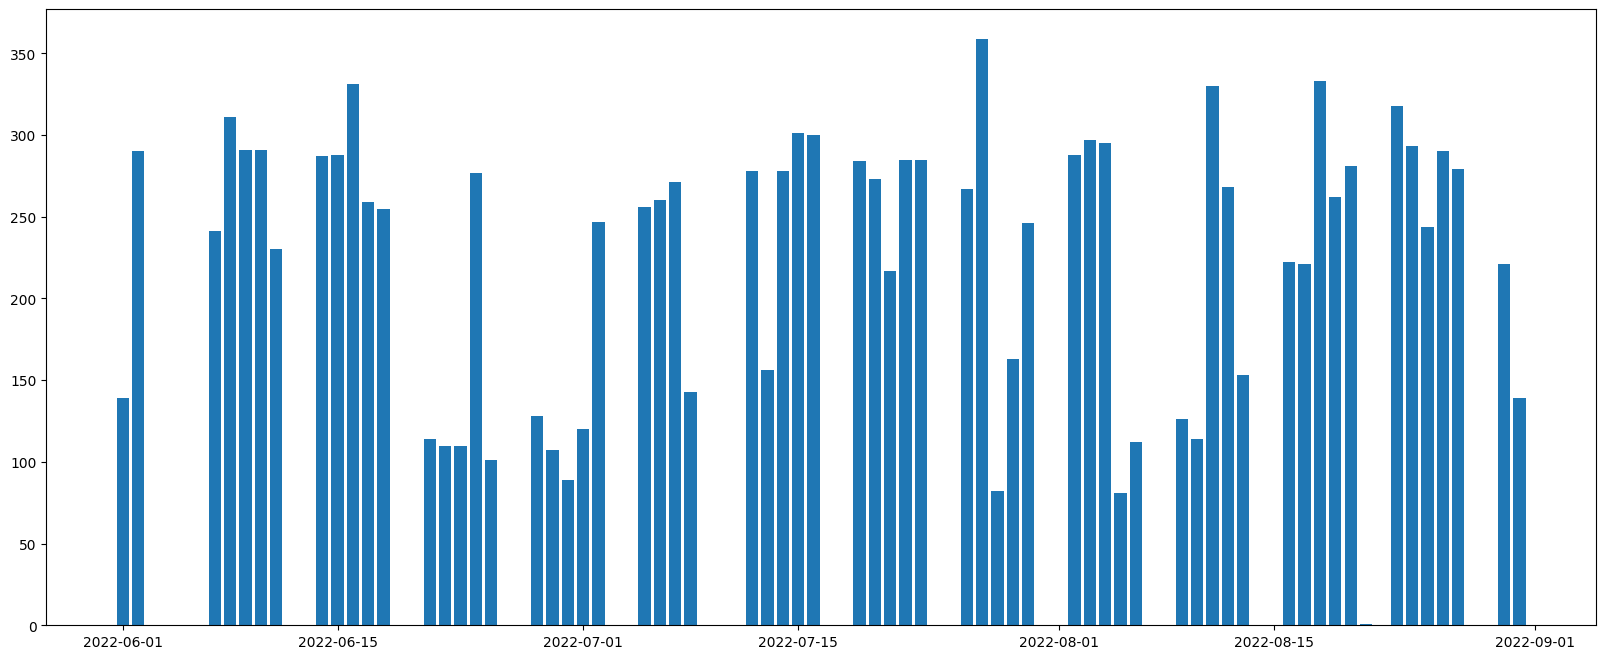

In [6]:
# volumes_totais_diarios['Volume'].plot(kind='bar', figsize = (15,8));
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])

## Media Movel

### Escolhendo melhor numero de janela para a media movel (baseado no erro)

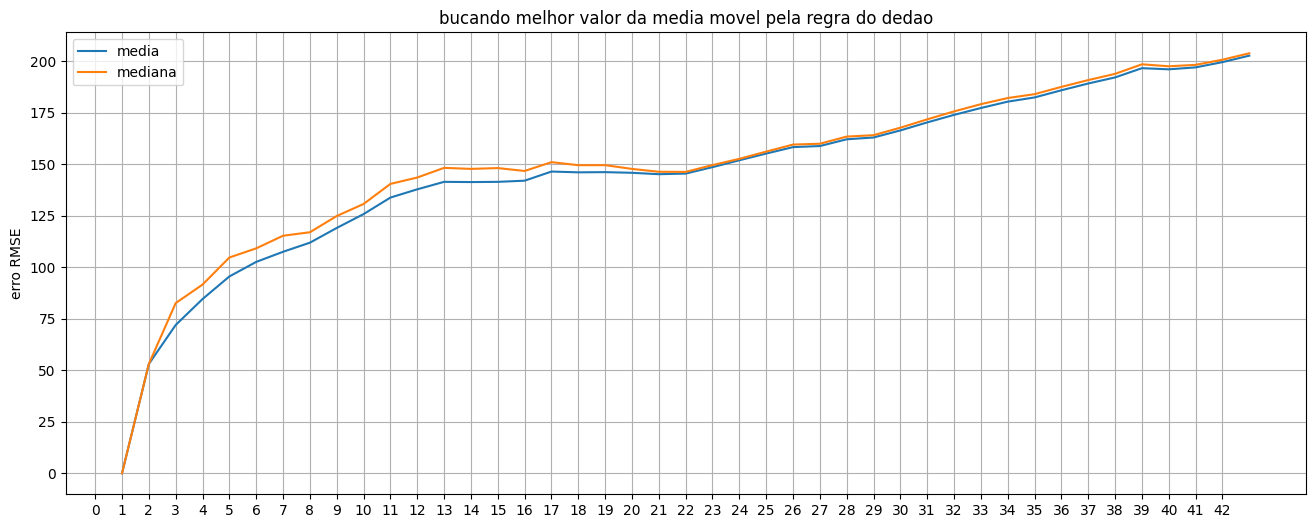

In [7]:
plt.rcParams["figure.figsize"] = (16,6)

erros_MA_diario = moving_average_test(volumes_totais_diarios)
erros_MM_diario = moving_median_test(volumes_totais_diarios)

plt.plot(erros_MA_diario.n_window, erros_MA_diario.RMSE)
plt.plot(erros_MM_diario.n_window, erros_MM_diario.RMSE)
plt.xticks([i for i in range(erros_MA_diario.shape[0])])
plt.legend(loc= 'best',labels = ['media', 'mediana'])
plt.ylabel('erro RMSE')
plt.title('bucando melhor valor da media movel pela regra do dedao')
plt.grid(visible=True, which = 'both')

plt.show()



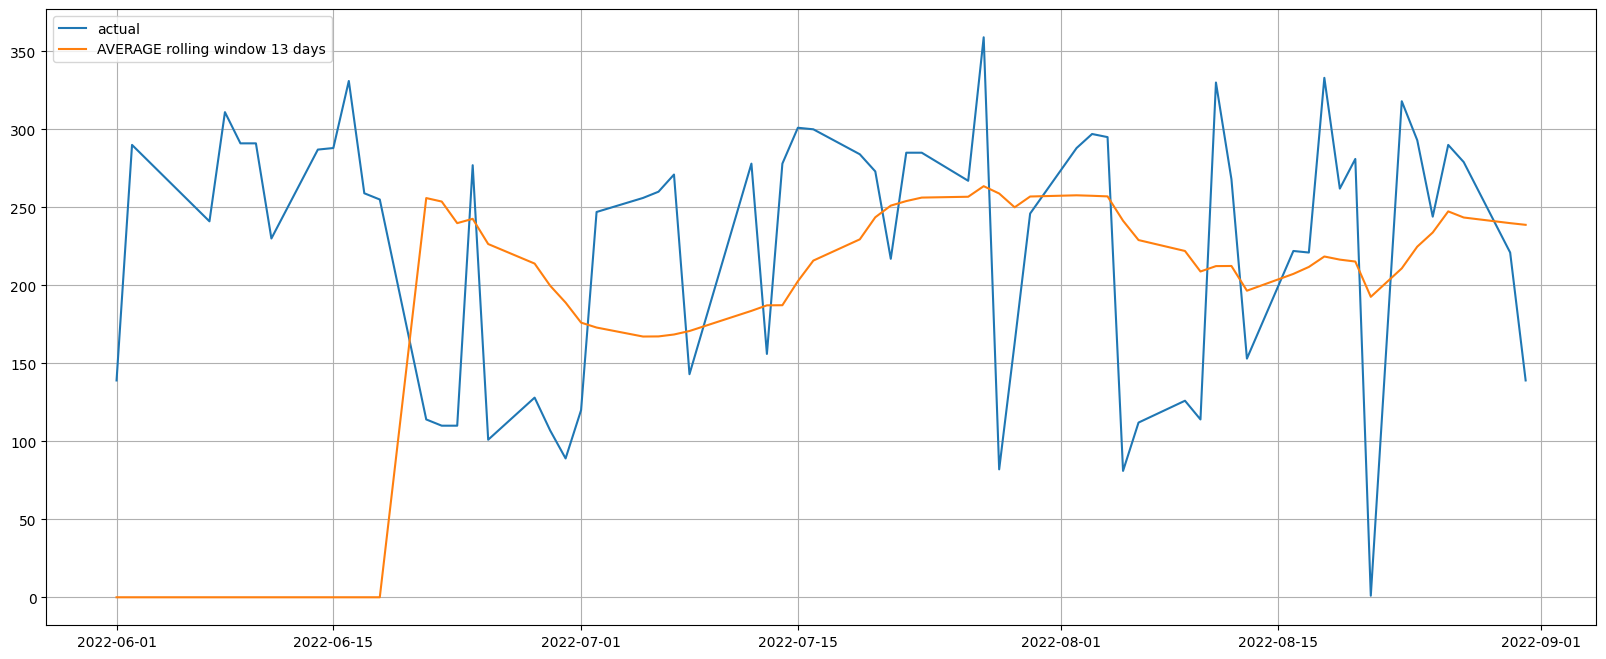

In [12]:
parametro = 13

volumes_totais_diarios['media_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).mean().fillna(0)
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])
plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['media_movel_' + str(parametro)])
plt.grid(visible=True)

# volumes_totais_diarios['mediana_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).median()
# plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['mediana_movel_' + str(parametro)], color = 'purple')

plt.legend(loc = 'upper left', labels = ['actual', 'AVERAGE rolling window {} days'.format(parametro), 'MEDIAN rolling window {} days'.format(parametro)])


plt.show()

### Modelagem Media Movel

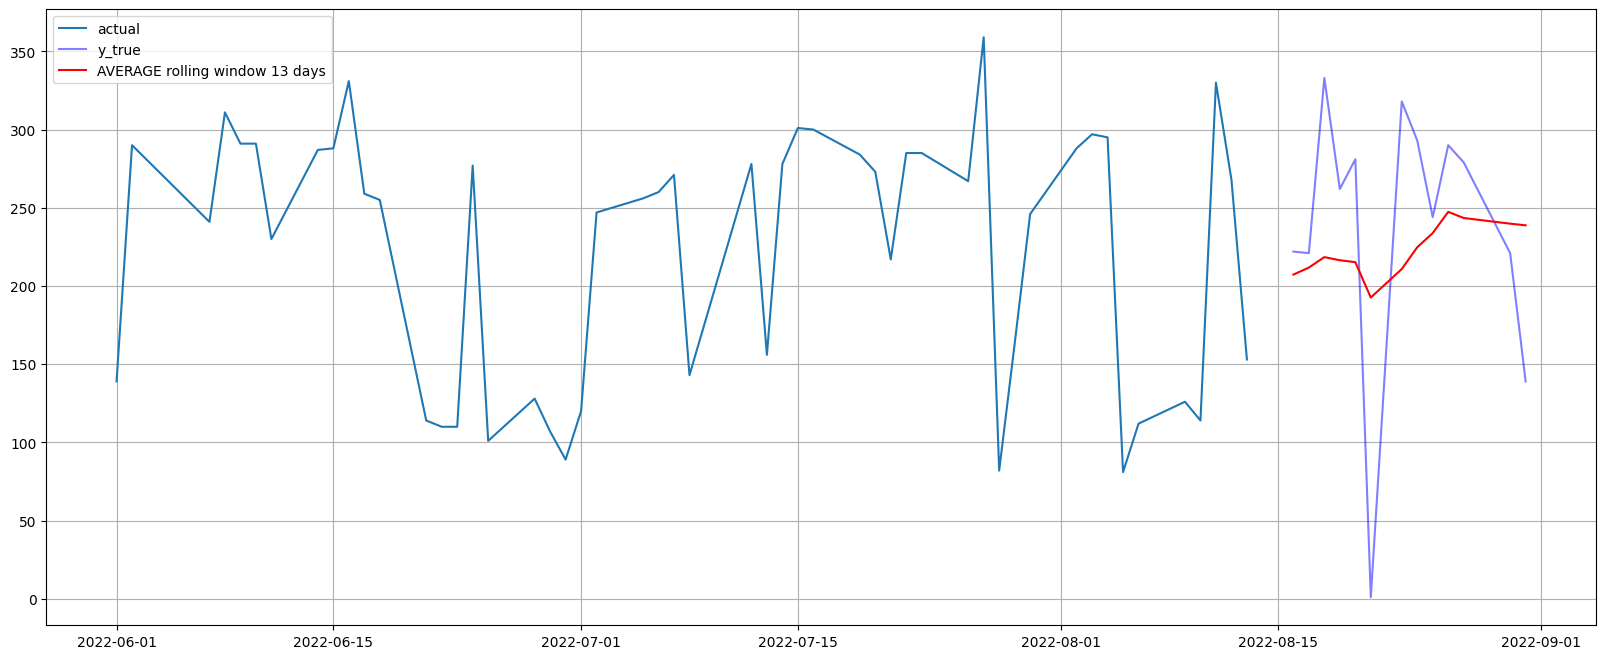

In [13]:
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(volumes_totais_diarios[:volumes_totais_diarios.shape[0]-parametro]['Data'], volumes_totais_diarios[:volumes_totais_diarios.shape[0]-parametro]['Volume'])
plt.plot(volumes_totais_diarios[-parametro:]['Data'], volumes_totais_diarios[-parametro:]['Volume'],color = 'blue', alpha = 0.5)
# plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])
plt.plot(volumes_totais_diarios[-parametro:]['Data'], volumes_totais_diarios[-parametro:]['media_movel_' + str(parametro)],color = 'red')
plt.grid(visible=True)

# volumes_totais_diarios['mediana_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).median()
# plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['mediana_movel_' + str(parametro)], color = 'purple')

plt.legend(loc = 'upper left', labels = ['actual','y_true' , 'AVERAGE rolling window {} days'.format(parametro)])


plt.show()

### calculo do erro

In [15]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(volumes_totais_diarios['Volume'],
                            volumes_totais_diarios['media_movel_' + str(parametro)],
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(volumes_totais_diarios[-parametro:]['Volume'],
                            volumes_totais_diarios[-parametro:]['media_movel_' + str(parametro)],
                            squared=False))



erro (RMSE) da modelagem 	 141.4673241094228
erro (RMSE) da previsao 	 81.41278692738923


## Suavizacao Exponencial


In [ ]:
TimeSeriesSplit()

In [28]:

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(X)
print(y)

[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]
 [3 4]]
[1 2 3 4 5 6]


In [25]:

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


In [26]:
# Fix test_size to 2 with 12 samples
X = np.random.randn(12, 2)
y = np.random.randint(0, 2, 12)
tscv = TimeSeriesSplit(n_splits=3, test_size=2)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



TRAIN: [0 1 2 3 4 5] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10 11]


In [27]:
# Add in a 2 period gap
tscv = TimeSeriesSplit(n_splits=3, test_size=2, gap=2)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [0 1 2 3] TEST: [6 7]
TRAIN: [0 1 2 3 4 5] TEST: [8 9]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [10 11]


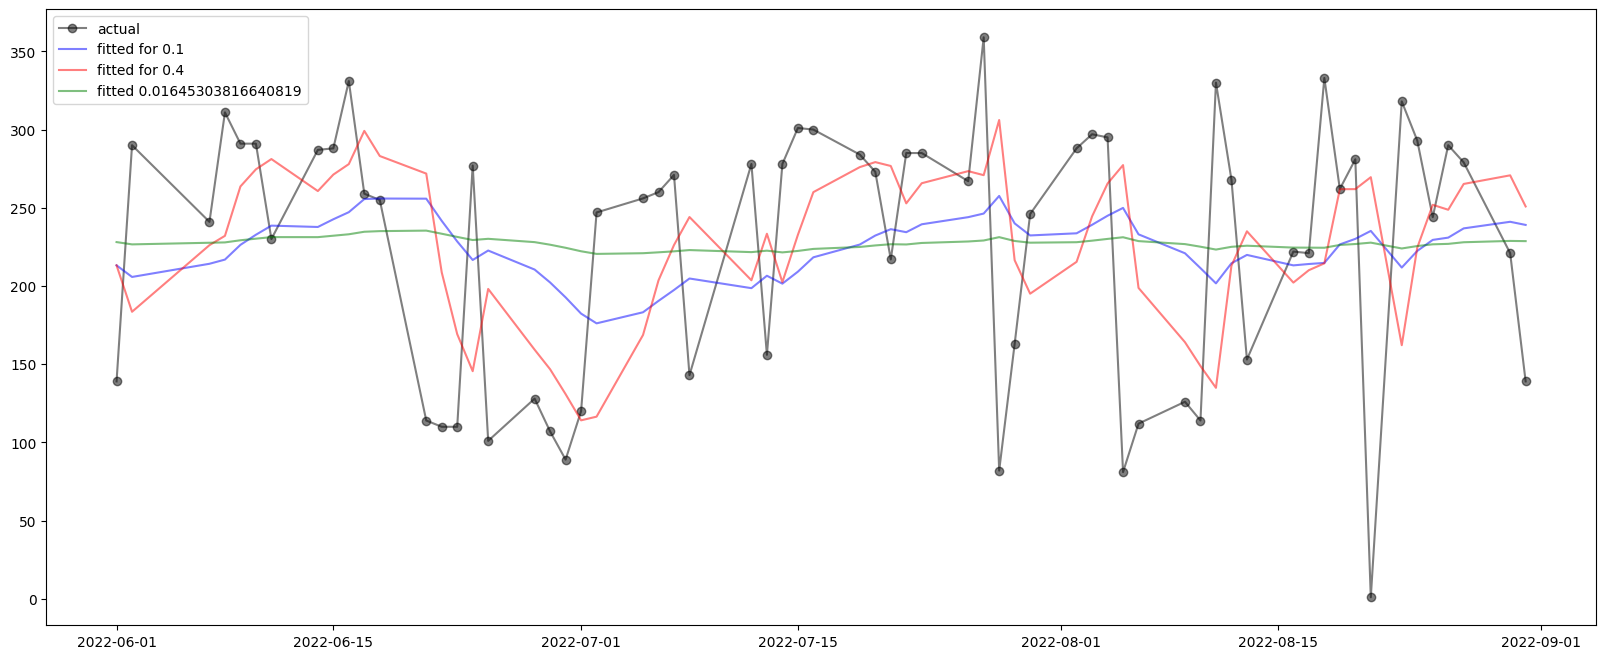

In [ ]:
fit1 = SimpleExpSmoothing(volumes_totais_diarios['Volume'].values, initialization_method="heuristic").fit(smoothing_level=0.1, optimized=False)

fit2 = SimpleExpSmoothing(volumes_totais_diarios['Volume'].values, initialization_method="heuristic").fit(smoothing_level=0.4, optimized=False)

fit3 = SimpleExpSmoothing(volumes_totais_diarios['Volume'].values, initialization_method="estimated").fit()

volumes_totais_diarios['SESfit1'] = fit1.fittedvalues
volumes_totais_diarios['SESfit2'] = fit2.fittedvalues
volumes_totais_diarios['SESfit3'] = fit3.fittedvalues


plt.figure(figsize=(20, 8))
plt.plot(volumes_totais_diarios['Data'],volumes_totais_diarios['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(volumes_totais_diarios['Data'],fit1.fittedvalues, color="blue", alpha = 0.5)
plt.plot(volumes_totais_diarios['Data'],fit2.fittedvalues, color="red" , alpha = 0.5)
plt.plot(volumes_totais_diarios['Data'],fit3.fittedvalues, color="green", alpha = 0.5)

plt.legend(loc = 'upper left', labels = ['actual', 'fitted for 0.1', 'fitted for 0.4', 'fitted {}'.format(fit3.model.params["smoothing_level"])])


### calculo do erro

In [ ]:
volumes_totais_diarios['error1'] = abs(volumes_totais_diarios['Volume'] - volumes_totais_diarios['SESfit1'])
volumes_totais_diarios['error2'] = abs(volumes_totais_diarios['Volume'] - volumes_totais_diarios['SESfit2'])
volumes_totais_diarios['error3'] = abs(volumes_totais_diarios['Volume'] - volumes_totais_diarios['SESfit3'])

print( 'erro absoluto medio MAE para suavizacao 1 ',volumes_totais_diarios['error1'].mean())
print( 'erro absoluto medio MAE para suavizacao 2 ',volumes_totais_diarios['error2'].mean())
print( 'erro absoluto medio MAE para suavizacao 3 ',volumes_totais_diarios['error3'].mean())


erro absoluto medio MAE para suavizacao 1  72.12609959868378
erro absoluto medio MAE para suavizacao 2  66.09149647333419
erro absoluto medio MAE para suavizacao 3  70.92195318516806


In [ ]:
volumes_totais_diarios['Volume'].mean()

226.375

In [ ]:
### MEDIA PERFORMA MELHOR QUE SUAVIZACAO EXPONENCIAL MAIS APURADA

abs(volumes_totais_diarios['Volume'] - volumes_totais_diarios['Volume'].mean()).mean()

70.75

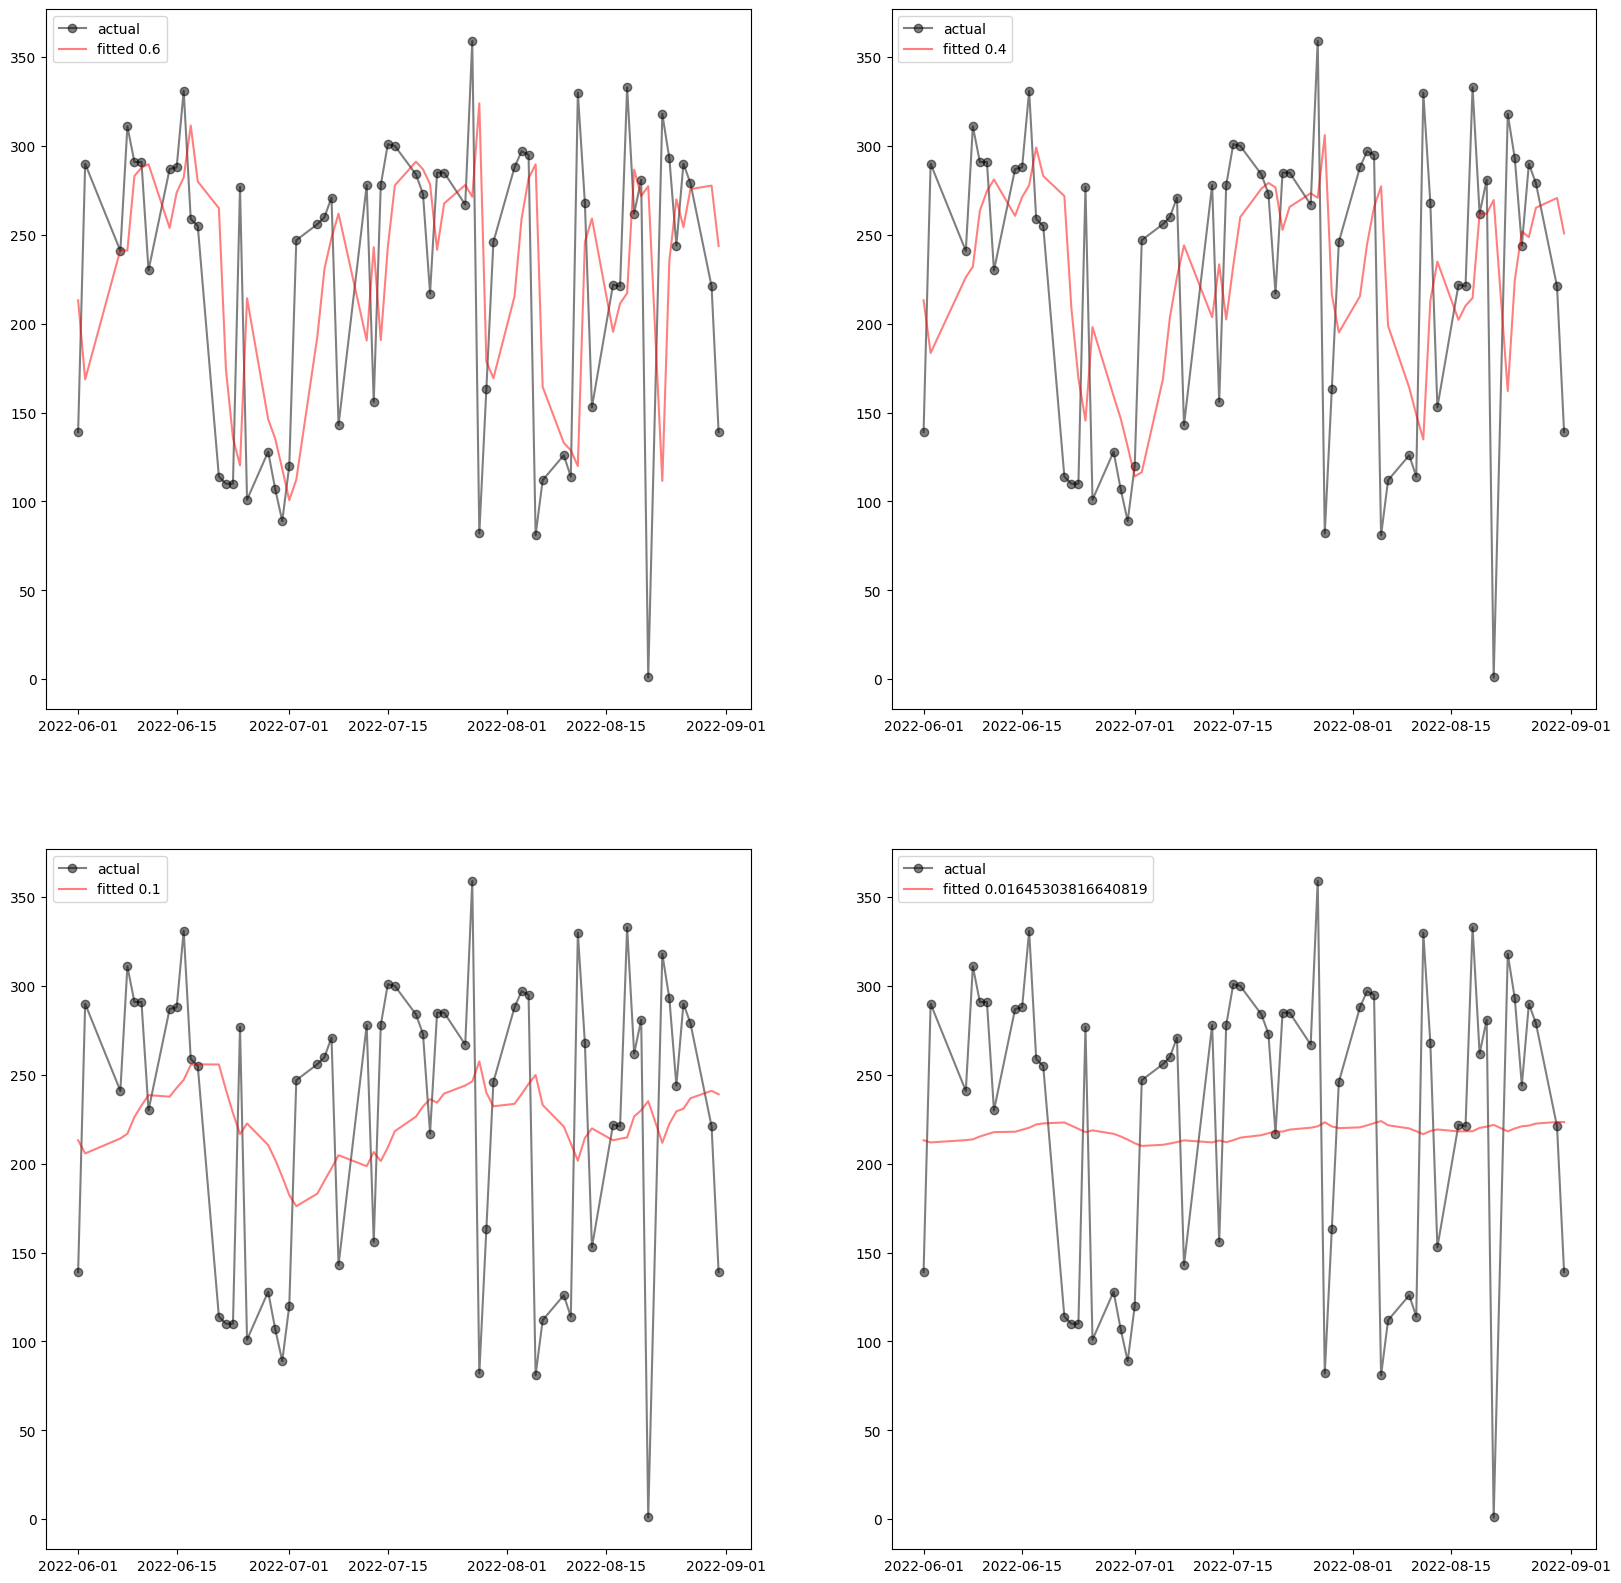

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(20, 20) )


params = [0.6,0.4, 0.1,fit3.model.params["smoothing_level"] ]
i = 0
for row in range(0,2):
    for col in range(0,2):

        fit1 = SimpleExpSmoothing(volumes_totais_diarios['Volume'].values, initialization_method="heuristic").fit(smoothing_level=params[i], optimized=False)
        # print(row, col,params[i], ax[row][col])

        ax[row][col].plot(volumes_totais_diarios['Data'],volumes_totais_diarios['Volume'], marker="o", color="black", alpha = 0.5)
        ax[row][col].plot(volumes_totais_diarios['Data'],fit1.fittedvalues, color="red", alpha = 0.5)
        ax[row][col].legend(loc = 'upper left', labels = ['actual', 'fitted {}'.format(params[i])])


        i +=1

plt.show()



### como calcular o erro da suaviazao exponencial?

In [ ]:
# SimpleExpSmoothing(volumes_totais_diarios['Volume'].values, initialization_method="heuristic").score( np.ndarray(1))



## Metodo de Holt

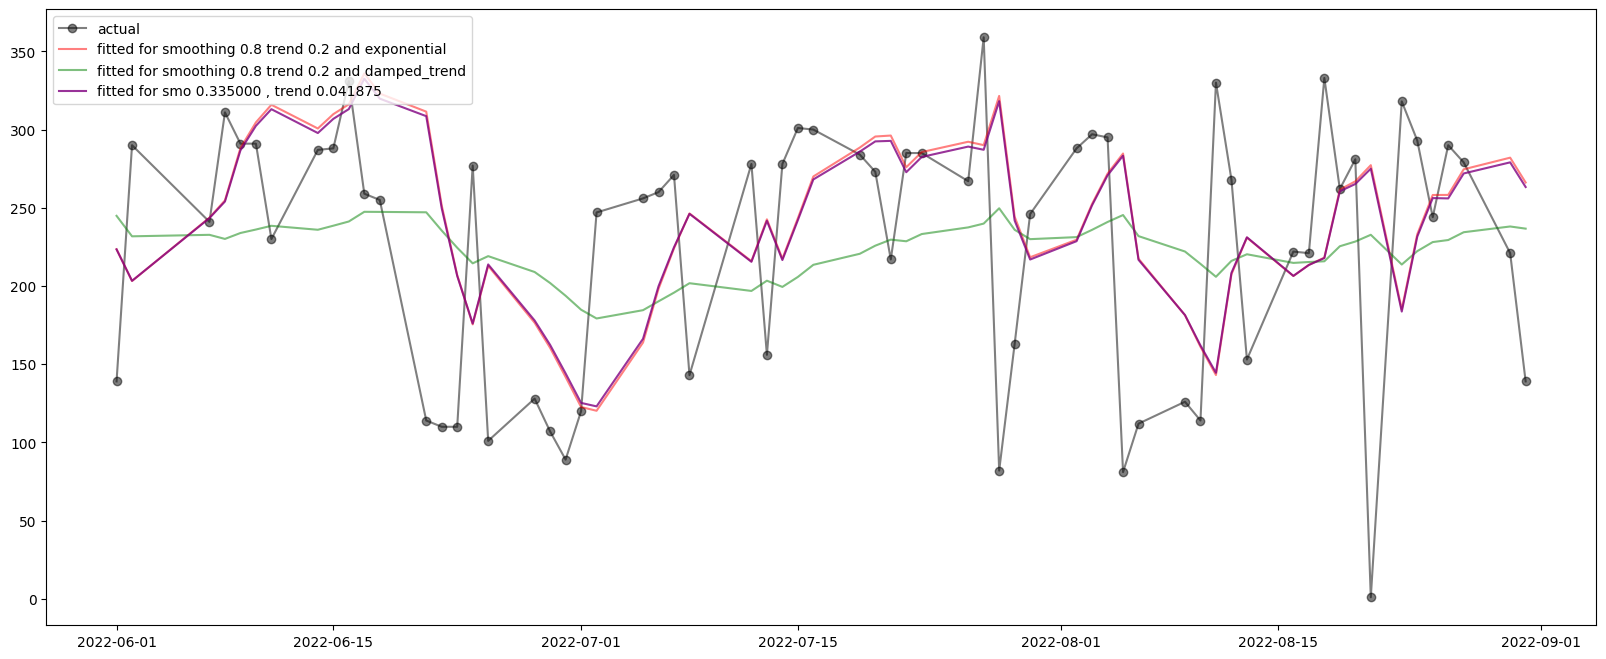

In [ ]:
# fit_holts1 = Holt(volumes_totais_diarios['Volume'].values, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)

fit_holts2 = Holt(volumes_totais_diarios['Volume'].values, exponential=True, initialization_method="estimated").fit(optimized=True)

fit_holts3 = Holt(volumes_totais_diarios['Volume'].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)

fit_holts4 = Holt(volumes_totais_diarios['Volume'].values,exponential=True, damped_trend=True, initialization_method="estimated").fit(optimized=True)

# volumes_totais_diarios['HOLTS_fit1'] = fit_holts1.fittedvalues
volumes_totais_diarios['HOLTS_fit2'] = fit_holts2.fittedvalues
volumes_totais_diarios['HOLTS_fit3'] = fit_holts3.fittedvalues
volumes_totais_diarios['HOLTS_fit4'] = fit_holts4.fittedvalues

plt.figure(figsize=(20, 8))
plt.plot(volumes_totais_diarios['Data'],volumes_totais_diarios['Volume'].values, marker="o", color="black", alpha = 0.5)
# plt.plot(volumes_totais_diarios['Data'],fit_holts1.fittedvalues, color="blue", alpha = 0.5)
plt.plot(volumes_totais_diarios['Data'],fit_holts2.fittedvalues, color="red", alpha = 0.5)
plt.plot(volumes_totais_diarios['Data'],fit_holts3.fittedvalues, color="green", alpha = 0.5)
plt.plot(volumes_totais_diarios['Data'],fit_holts4.fittedvalues, color="purple", alpha = 0.8)

plt.legend(loc = 'upper left', labels = ['actual', 
                                # 'fitted for smoothing 0.8 trend 0.2', 
                                'fitted for smoothing 0.8 trend 0.2 and exponential', 
                                'fitted for smoothing 0.8 trend 0.2 and damped_trend',
                                'fitted for smo {:2f} , trend {:2f}'.format(fit_holts4.model.params["smoothing_level"], fit_holts4.model.params["smoothing_trend"])])



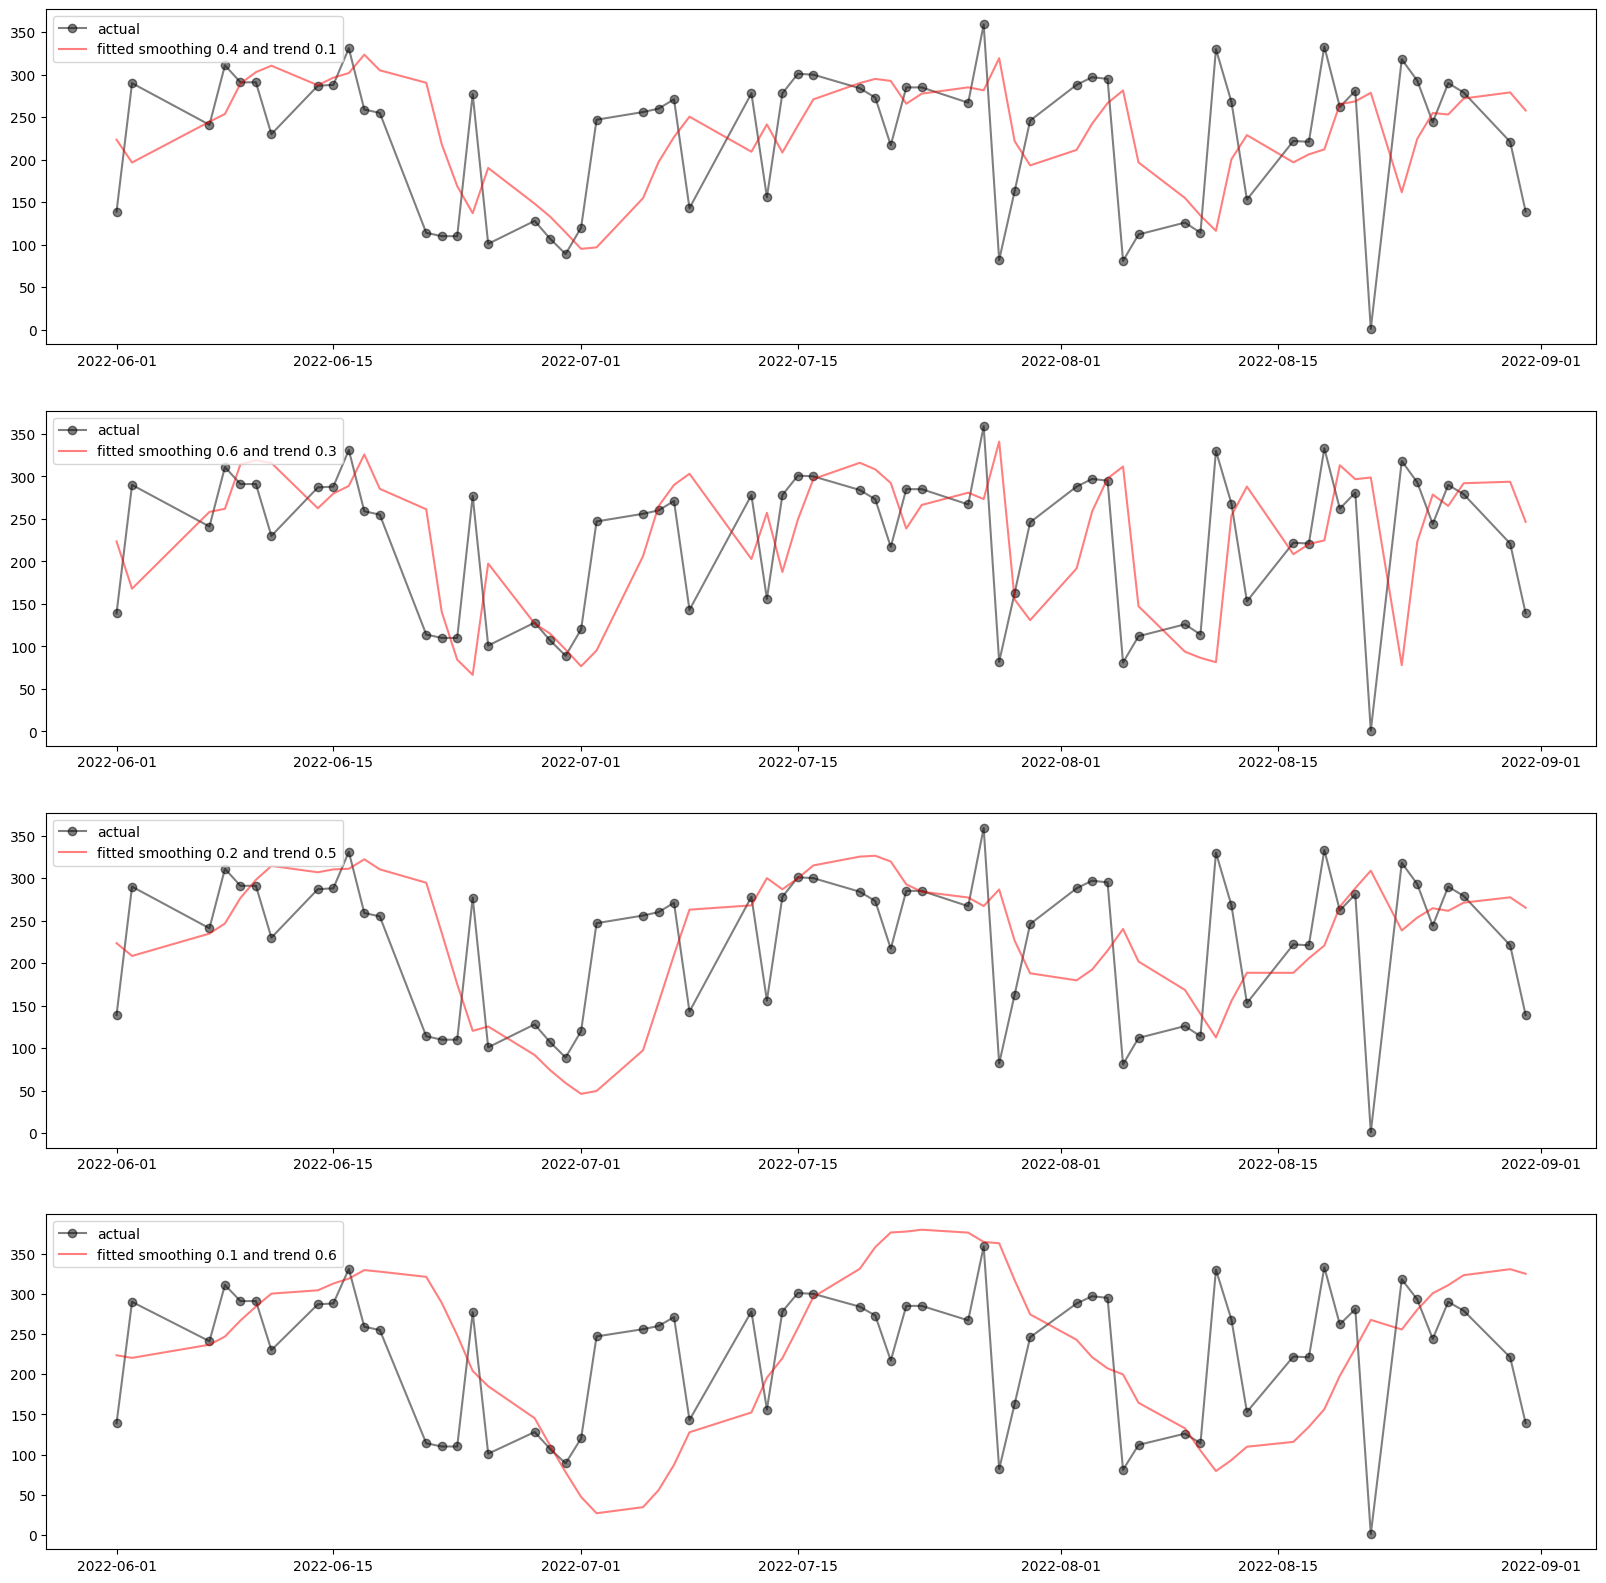

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=4,figsize=(20, 20) )

params_alpha = [0.4,0.6,0.2, 0.1]
params_beta = [0.1,0.3,0.5, 0.6]
i = 0
for row in range(0,4):

    fit1 = Holt(volumes_totais_diarios['Volume'].values, initialization_method="estimated").fit(smoothing_level=params_alpha[i], smoothing_trend=params_beta[i], optimized=False)
    # print(row, col,params[i], ax[row][col])

    ax[row].plot(volumes_totais_diarios['Data'],volumes_totais_diarios['Volume'], marker="o", color="black", alpha = 0.5)
    ax[row].plot(volumes_totais_diarios['Data'],fit1.fittedvalues, color="red", alpha = 0.5)
    ax[row].legend(loc = 'upper left', labels = ['actual', 'fitted smoothing {} and trend {}'.format(params_alpha[i], params_beta[i])])


    i +=1

plt.show()



#### como calcular o erro do metodo de holt?

O metodo de holts tem 2 hyperparametros serem ajustados, mas tambem uma serie de metodos de calculo que variam os resultados
 - exponential=True
 - damped_trend=True
 - entre outros 

In [ ]:
volumes_totais_diarios['error1'] = abs(volumes_totais_diarios['Volume'] - volumes_totais_diarios['HOLTS_fit1'])
volumes_totais_diarios['error2'] = abs(volumes_totais_diarios['Volume'] - volumes_totais_diarios['HOLTS_fit2'])
volumes_totais_diarios['error3'] = abs(volumes_totais_diarios['Volume'] - volumes_totais_diarios['HOLTS_fit3'])

print( 'erro absoluto medio MAE para holts 1 ',volumes_totais_diarios['error1'].mean())
print( 'erro absoluto medio MAE para holts 2 ',volumes_totais_diarios['error2'].mean())
print( 'erro absoluto medio MAE para holts 3 ',volumes_totais_diarios['error3'].mean())


erro absoluto medio MAE para holts 1  71.18505985507144
erro absoluto medio MAE para holts 2  84.81446451898546
erro absoluto medio MAE para holts 3  70.59010280076679


# Volume por dia da semana

## Organizacao dos volumes por dias da semana

0    3030
1    3067
2    3161
3    2740
4    2489
5       1
Name: dataInicio, dtype: int64


<AxesSubplot:>

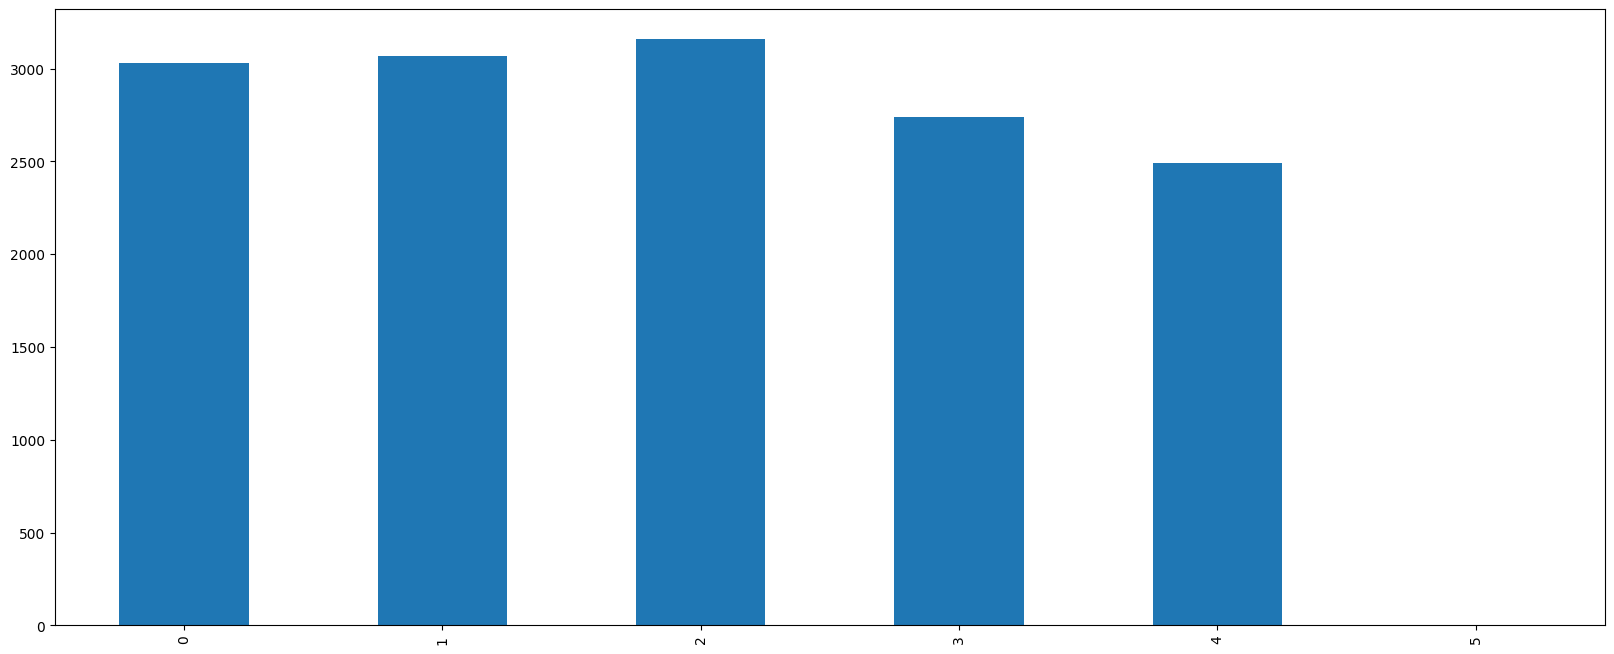

In [ ]:
# 0 --> segunda
print(viagens_validas.dataInicio.dt.day_of_week.value_counts().sort_index())
viagens_validas.dataInicio.dt.day_of_week.value_counts().sort_index().plot(kind = 'bar' )


In [ ]:
vol_semanal = viagens_validas.groupby(['day_of_week', pd.Grouper(freq='1D',key = 'dataInicio')]).agg({'sequence':'count'}).reset_index()
vol_semanal.drop(index = vol_semanal.loc[vol_semanal['day_of_week'] == 5].index,inplace = True, axis = 0)
vol_semanal.columns = ['day_of_week',	'Data',	'Volume']

vol_semanal

,day_of_week,Data,Volume
0,0,2021-06-07,241
1,0,2021-06-14,287
2,0,2021-06-21,114
3,0,2021-06-28,128
4,0,2021-07-05,256
...,...,...,...
58,4,2021-07-30,246
59,4,2021-08-06,112
60,4,2021-08-13,153
61,4,2021-08-20,281


In [ ]:
segundas =  vol_semanal.loc[vol_semanal['day_of_week'] == 0]
tercas =    vol_semanal.loc[vol_semanal['day_of_week'] == 1]
quartas =   vol_semanal.loc[vol_semanal['day_of_week'] == 2]
quintas =   vol_semanal.loc[vol_semanal['day_of_week'] == 3]
sextas =    vol_semanal.loc[vol_semanal['day_of_week'] == 4]

In [ ]:
segundas

,day_of_week,Data,Volume
0,0,2021-06-07,241
1,0,2021-06-14,287
2,0,2021-06-21,114
3,0,2021-06-28,128
4,0,2021-07-05,256
5,0,2021-07-12,278
6,0,2021-07-19,284
7,0,2021-07-26,267
8,0,2021-08-02,288
9,0,2021-08-09,126


/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/2582163071.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0][0].set_xticklabels(labels = segundas   .Data , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/2582163071.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0][1].set_xticklabels(labels = tercas     .Data , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/2582163071.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][0].set_xticklabels(labels = quartas    .Data , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/2582163071.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels(labels = quintas    .Data , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/2582163071.py:25: UserW

[Text(18779.0, 0, '2021-06-11 00:00:00'),
 Text(18793.0, 0, '2021-06-18 00:00:00'),
 Text(18809.0, 0, '2021-06-25 00:00:00'),
 Text(18823.0, 0, '2021-07-02 00:00:00'),
 Text(18840.0, 0, '2021-07-16 00:00:00'),
 Text(18854.0, 0, '2021-07-23 00:00:00'),
 Text(18871.0, 0, '2021-07-30 00:00:00')]

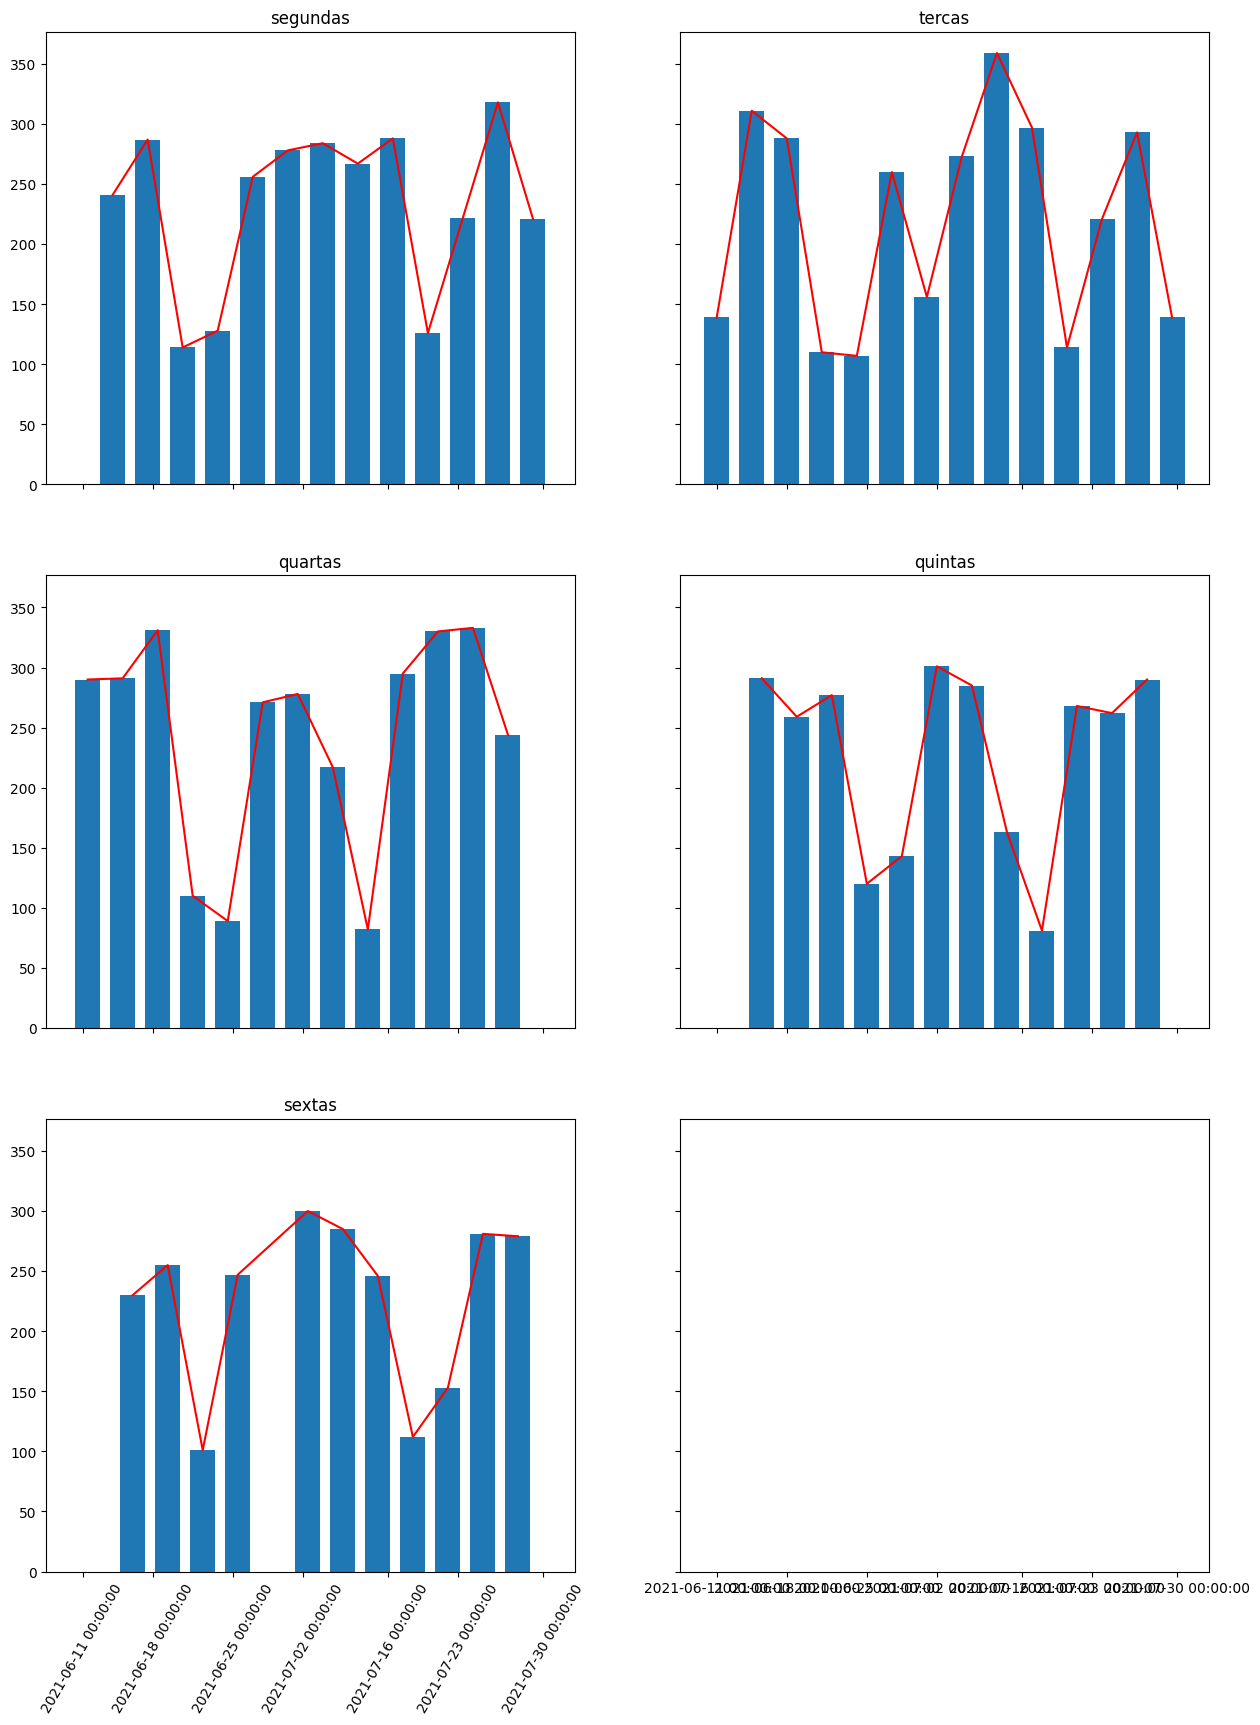

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(15,20), sharex= True, sharey = True)

ax[0][0].bar(segundas   .Data, segundas   .Volume, width = 5)
ax[0][1].bar(tercas     .Data, tercas     .Volume, width = 5)
ax[1][0].bar(quartas    .Data, quartas    .Volume, width = 5)
ax[1][1].bar(quintas    .Data, quintas    .Volume, width = 5)
ax[2][0].bar(sextas     .Data, sextas     .Volume, width = 5)

ax[0][0].plot(segundas   .Data, segundas   .Volume, color = 'red')
ax[0][1].plot(tercas     .Data, tercas     .Volume, color = 'red')
ax[1][0].plot(quartas    .Data, quartas    .Volume, color = 'red')
ax[1][1].plot(quintas    .Data, quintas    .Volume, color = 'red')
ax[2][0].plot(sextas     .Data, sextas     .Volume, color = 'red')

ax[0][0].set_title('segundas')
ax[0][1].set_title('tercas')
ax[1][0].set_title('quartas')
ax[1][1].set_title('quintas')
ax[2][0].set_title('sextas')

ax[0][0].set_xticklabels(labels = segundas   .Data , rotation = 60)
ax[0][1].set_xticklabels(labels = tercas     .Data , rotation = 60)
ax[1][0].set_xticklabels(labels = quartas    .Data , rotation = 60)
ax[1][1].set_xticklabels(labels = quintas    .Data , rotation = 60)
ax[2][0].set_xticklabels(labels = sextas     .Data , rotation = 60)

# segundas.Data.dt.date.value_counts().sort_index().plot(kind = 'bar' ,figsize=(8,5))
# segundas.Data.dt.date.value_counts().sort_index().plot(kind = 'bar' ,figsize=(8,5))

## Media Movel

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/4147941158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['media_movel3'] = df['Volume'].rolling(3).mean()
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/4147941158.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/4147941158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

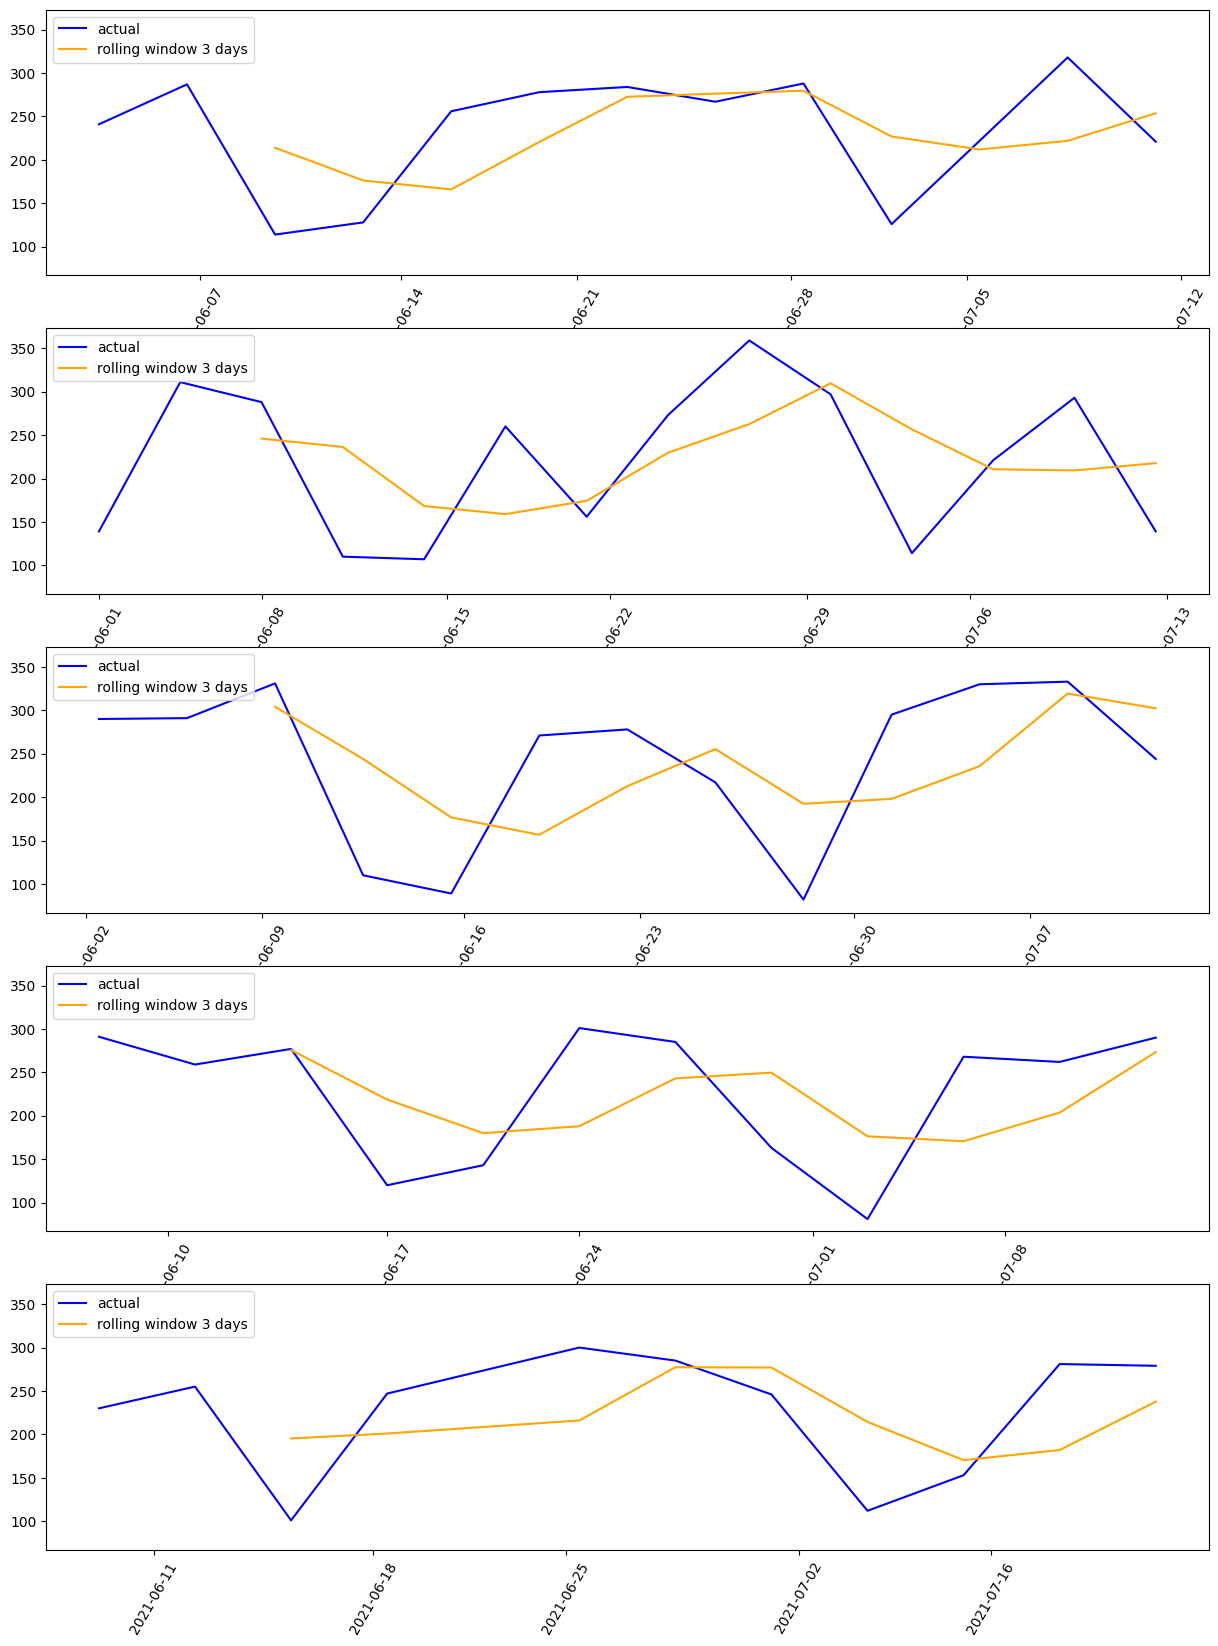

In [ ]:

fig, ax = plt.subplots(nrows=5,figsize=(15,20), sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    df['media_movel3'] = df['Volume'].rolling(3).mean()
    ax[idx].plot(df   .Data.dt.date, df   .Volume, color = 'blue')
    ax[idx].plot(df   .Data.dt.date, df   .media_movel3, color = 'orange')
    ax[idx].legend(loc = 'upper left', labels = ['actual', 'rolling window 3 days'])
    ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)

    # ax[idx].set_title('')
plt.show()

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/2876676256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['media_movel5'] = df['Volume'].rolling(5).mean()
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/2876676256.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/2876676256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

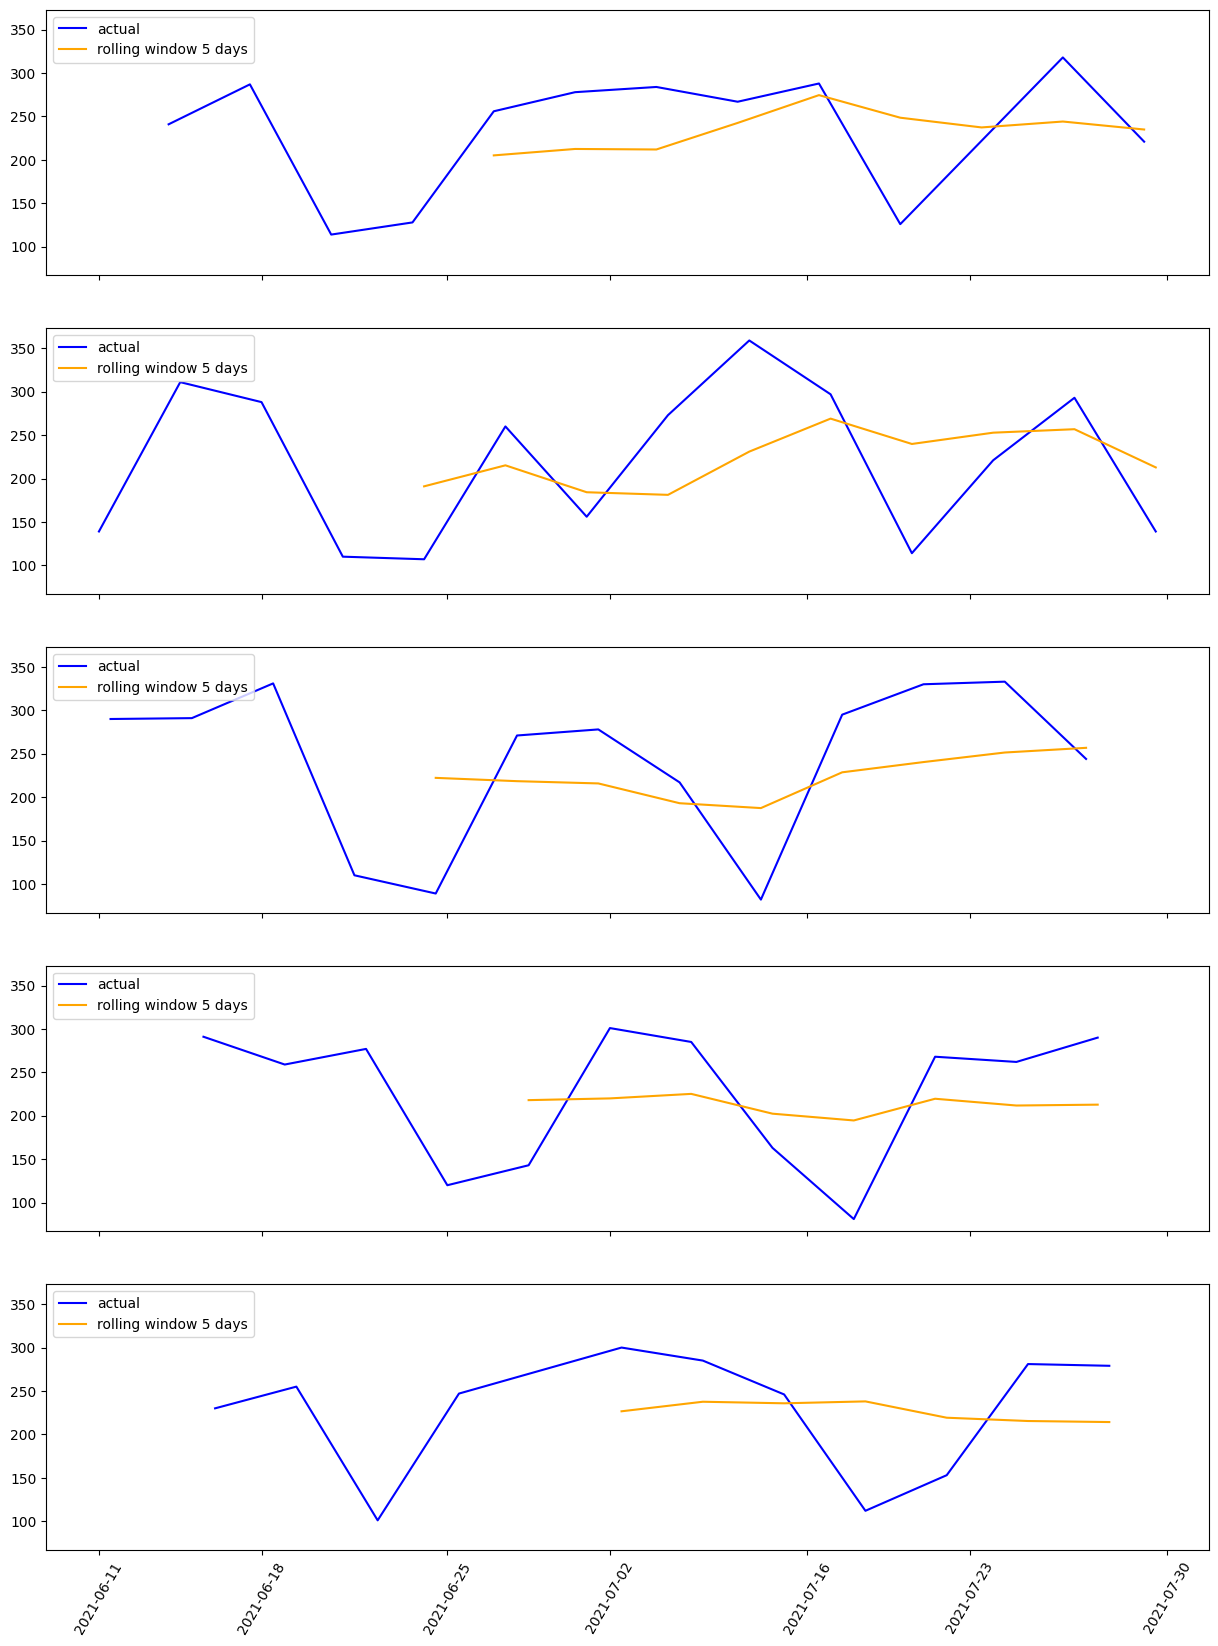

In [ ]:
fig, ax = plt.subplots(nrows=5,figsize=(15,20), sharex= True, sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    df['media_movel5'] = df['Volume'].rolling(5).mean()
    ax[idx].plot(df   .Data.dt.date, df   .Volume, color = 'blue')
    ax[idx].plot(df   .Data.dt.date, df   .media_movel5, color = 'orange')
    ax[idx].legend(loc = 'upper left', labels = ['actual', 'rolling window 5 days'])
    ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)

    # ax[idx].set_title('')

plt.show()

In [ ]:
sextas

,day_of_week,Data,Volume,media_movel3,media_movel5
52,4,2021-06-11,230,NaN,NaN
53,4,2021-06-18,255,NaN,NaN
54,4,2021-06-25,101,195.333333,NaN
55,4,2021-07-02,247,201.000000,NaN
56,4,2021-07-16,300,216.000000,226.6
57,4,2021-07-23,285,277.333333,237.6
58,4,2021-07-30,246,277.000000,235.8
59,4,2021-08-06,112,214.333333,238.0
60,4,2021-08-13,153,170.333333,219.2
61,4,2021-08-20,281,182.000000,215.4


### calculo do erro

In [ ]:
print('DF1 = Segundas')
print('DF2 = Tercas')
print('DF3 = Quartas')
print('DF4 = Quintas')
print('DF5 = Sextas')
print('******************************')

for idx, df in enumerate([segundas, tercas, df, quintas, sextas]):
    df['erro3'] = (df['media_movel3'] - df['Volume'])**2
    # print( 'erro3 quadratico soma do DF{}  '.format(idx+1),df['erro3'].sum())
    print( 'erro da MA(3) sqrt quadratico medio do DF{}  , RMSE'.format(idx+1),np.sqrt(df['erro3'].mean()))

    df['erro5'] = (df['media_movel5'] - df['Volume'])**2
    # print( 'erro5 quadratico soma do DF{}  '.format(idx+1),df['erro5'].sum())
    print( 'erro da MA(5) sqrt quadratico medio do DF{}  RMSE'.format(idx+1),np.sqrt(df['erro5'].mean()), end='\n')

    print('=====================================')

DF1 = Segundas
DF2 = Tercas
DF3 = Quartas
DF4 = Quintas
DF5 = Sextas
******************************
erro da MA(3) sqrt quadratico medio do DF1  , RMSE 63.669839679776835
erro da MA(5) sqrt quadratico medio do DF1  RMSE 61.216446591854165
erro da MA(3) sqrt quadratico medio do DF2  , RMSE 80.09912839956732
erro da MA(5) sqrt quadratico medio do DF2  RMSE 76.84222797394673
erro da MA(3) sqrt quadratico medio do DF3  , RMSE 67.80081575677355
erro da MA(5) sqrt quadratico medio do DF3  RMSE 72.2092198307905
erro da MA(3) sqrt quadratico medio do DF4  , RMSE 74.42632449461534
erro da MA(5) sqrt quadratico medio do DF4  RMSE 71.62558900281378
erro da MA(3) sqrt quadratico medio do DF5  , RMSE 67.80081575677355
erro da MA(5) sqrt quadratico medio do DF5  RMSE 72.2092198307905


/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/588385930.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['erro3'] = (df['media_movel3'] - df['Volume'])**2
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/588385930.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['erro5'] = (df['media_movel5'] - df['Volume'])**2
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_23662/588385930.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [ ]:
vol_semanal#.to_excel('vol_semanal.xlsx')

,day_of_week,Data,Volume
0,0,2021-06-07,241
1,0,2021-06-14,287
2,0,2021-06-21,114
3,0,2021-06-28,128
4,0,2021-07-05,256
...,...,...,...
58,4,2021-07-30,246
59,4,2021-08-06,112
60,4,2021-08-13,153
61,4,2021-08-20,281


## Suavizacao Exponencial


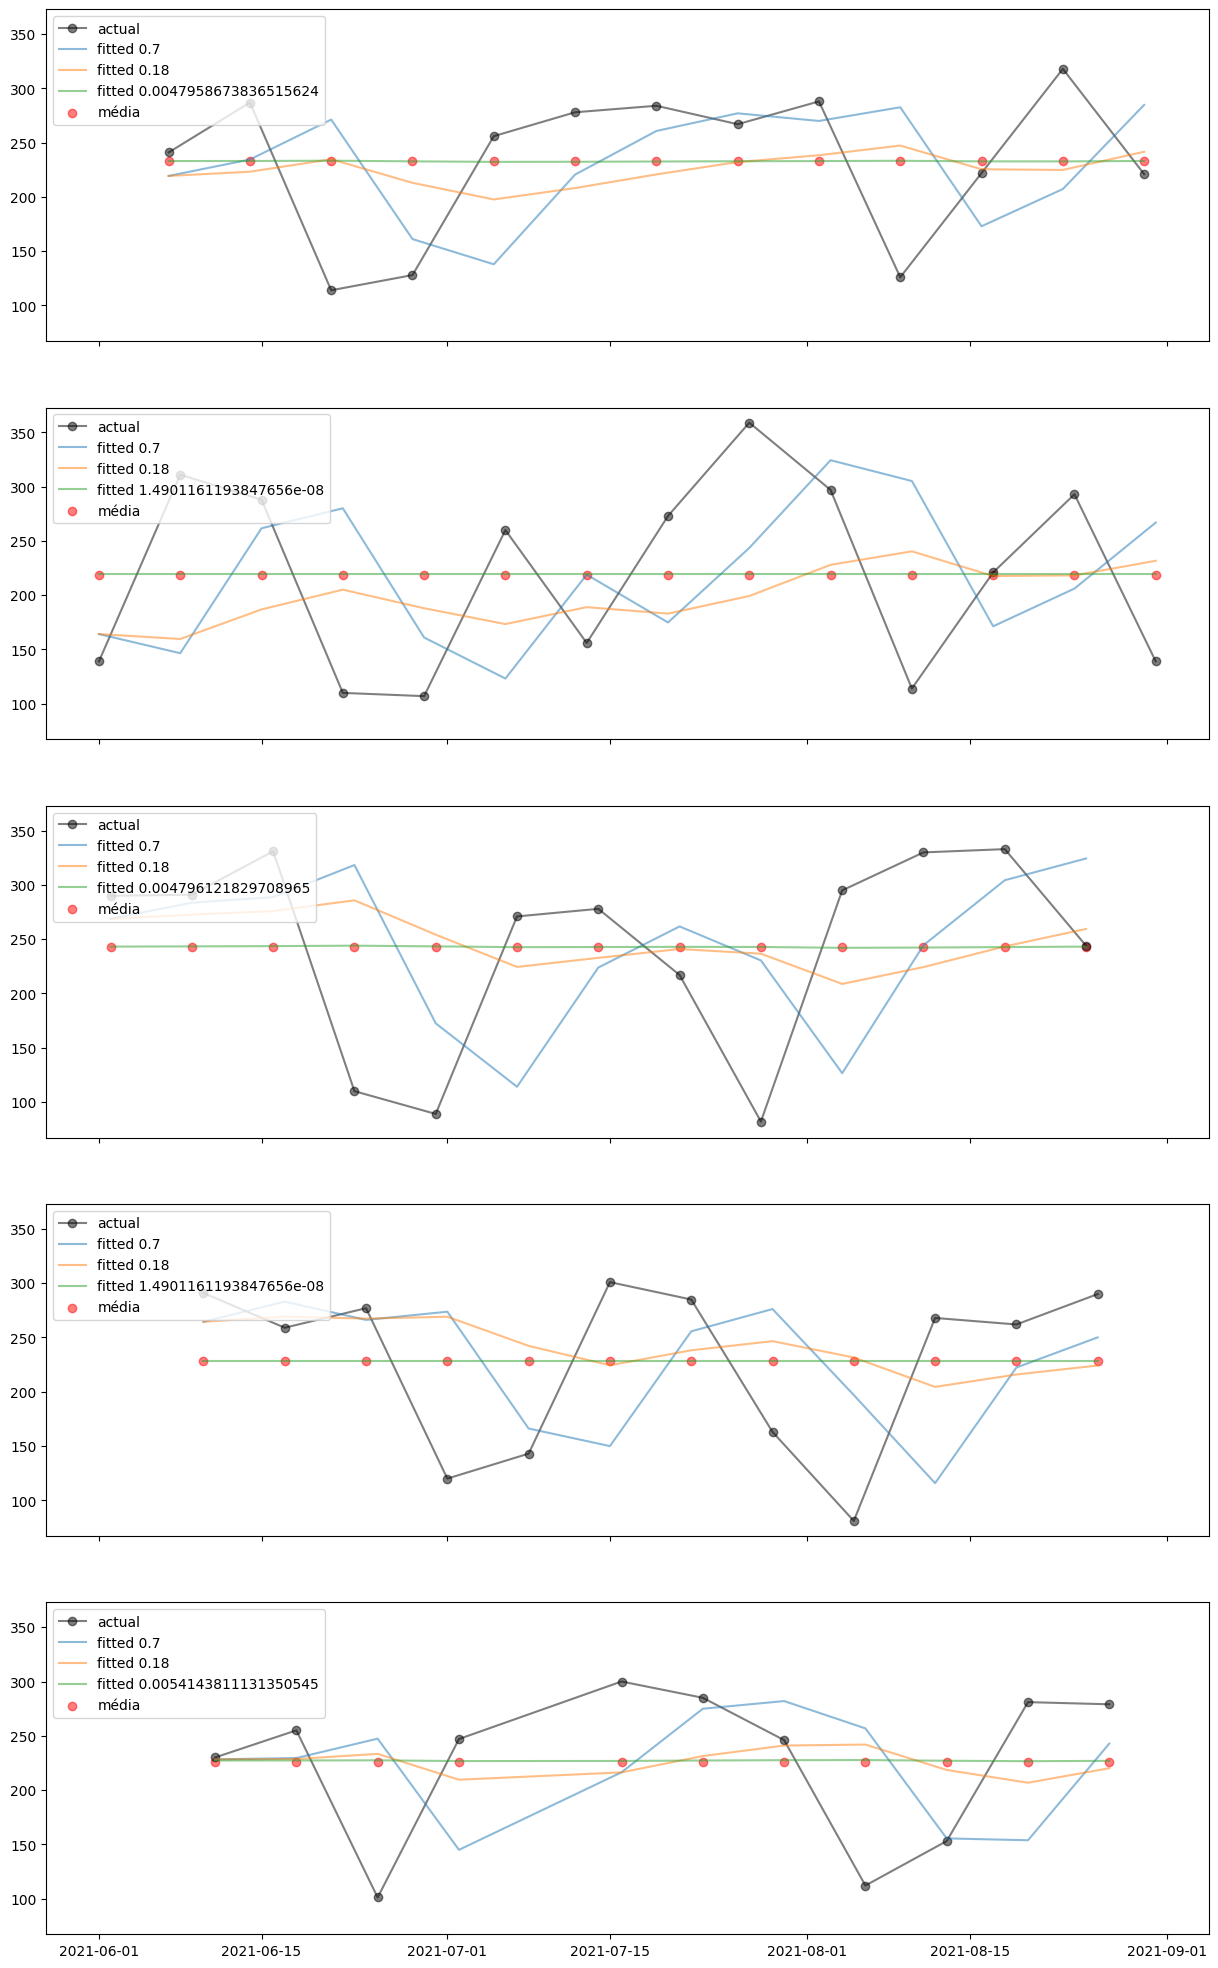

In [ ]:
fig, ax = plt.subplots(nrows=5,figsize=(15,25), sharex= True, sharey = True)

params = [0.7,0.18 ]

## um grafico para cada dia da semana
for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    ## para um grafico, adiciona a serie historica antes de tudo
    ax[idx].plot(df['Data'],df['Volume'], marker="o", color="black", alpha = 0.5)

    # vai gerar 3 modelos: 2 com parametros escolhidos, e um fitado para o melhor parametro
    for n_models in range(0,3): ###  0 1 2
        # gera modelo com parametros determinados
        if n_models != 2:
            fit1 = SimpleExpSmoothing(df['Volume'].values, initialization_method="heuristic").fit(smoothing_level=params[n_models], optimized=False)

        else:
            ## gera modelo com parametro alpha otimizado
            fit1 = SimpleExpSmoothing(df['Volume'].values, initialization_method="heuristic").fit()

        ax[idx].plot(df['Data'],fit1.fittedvalues,  alpha = 0.5)


    ################################# printa a media para comparar com as previsoes   #################################
    ax[idx].scatter(df['Data'],[df['Volume'].mean() for i in range(len(df['Volume']))], color='red', alpha = 0.5)


    ax[idx].legend(loc = 'upper left', labels = ['actual',
                                                 'fitted {}'.format(params[0]),
                                                 'fitted {}'.format(params[1]), 
                                                 'fitted {}'.format(fit1.model.params["smoothing_level"]),
                                                 'média'])

    # ax[idx].set_title('')

plt.show()

### como calcular o erro da suavizacao exponencial?

 - tem 3 modelagens pra cada dia da semana, seriam 15 calculos de erro
 - vamos primeiro validar se esses modelos fazem sentido pra algum das series temporais, depois avancar em so uma delas


In [ ]:
# SimpleExpSmoothing(volumes_totais_diarios['Volume'].values, initialization_method="heuristic").score( np.ndarray(1))



## Metodo de Holt

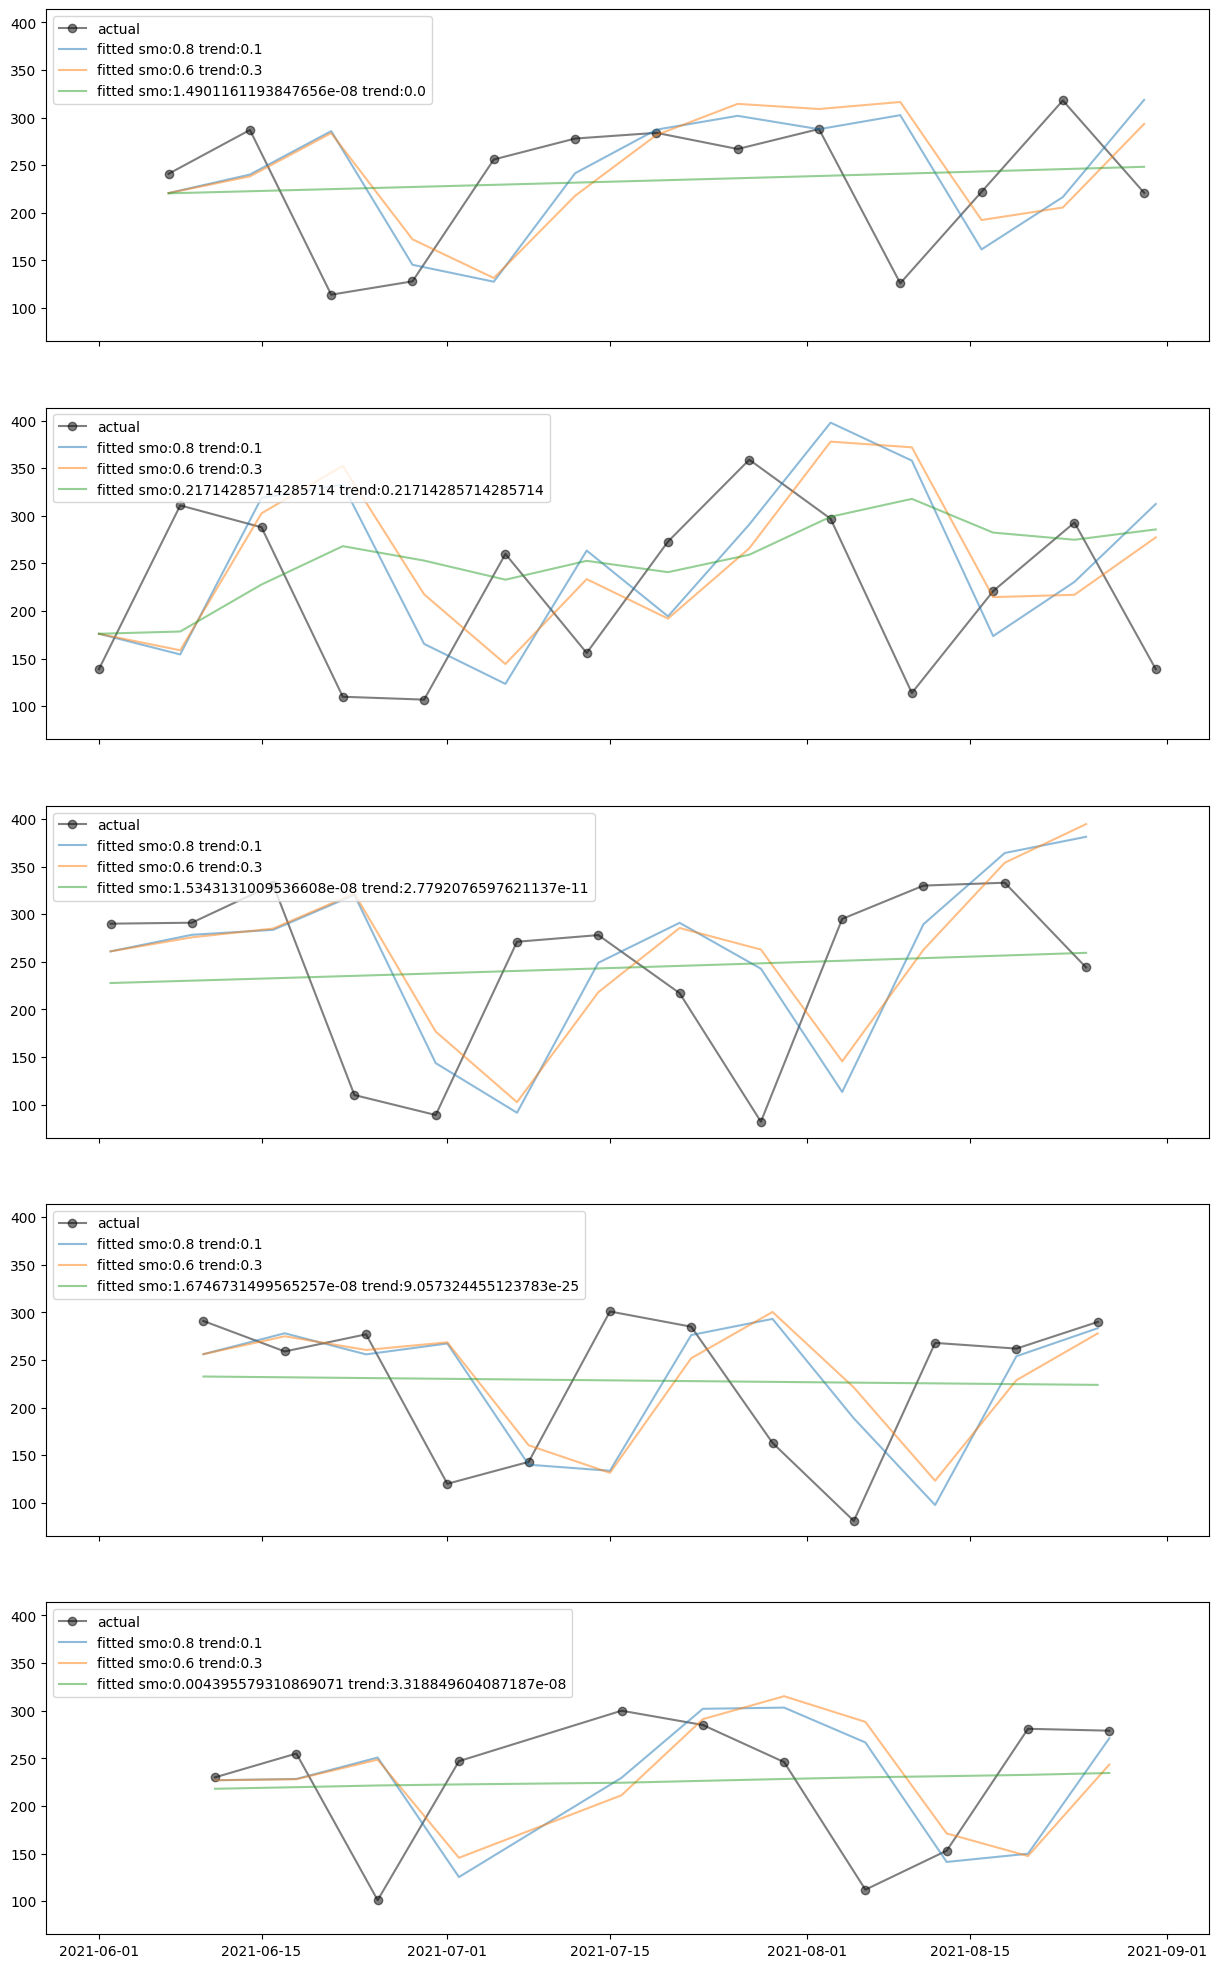

In [ ]:
fig, ax = plt.subplots(nrows=5,figsize=(15,25), sharex= True, sharey = True)


params_alpha = [0.8,0.6]
params_beta = [0.1,0.3]

## um grafico para cada dia da semana
for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    ## para um grafico, adiciona a serie historica antes de tudo
    ax[idx].plot(df['Data'],df['Volume'], marker="o", color="black", alpha = 0.5)

    # vai gerar 3 modelos: 2 com parametros escolhidos, e um fitado para o melhor parametro
    for n_models in range(0,3): ###  0 1 2
        # gera modelo com parametros determinados
        if n_models != 2:
            fit1 = Holt(df['Volume'].values, exponential=True,initialization_method="heuristic").fit(smoothing_level=params_alpha[n_models],
                                                                                                    smoothing_trend=params_beta[n_models], optimized=False)

        else:
            ## gera modelo com parametro alpha otimizado
            fit1 = Holt(df['Volume'].values, exponential=True,initialization_method="heuristic").fit(optimized=True)

        ax[idx].plot(df['Data'],fit1.fittedvalues,  alpha = 0.5)


    ################################# printa a media para comparar com as previsoes   #################################
    # ax[idx].scatter(df['Data'],[df['Volume'].mean() for i in range(len(df['Volume']))], color='red', alpha = 0.5)


    ax[idx].legend(loc = 'upper left', labels = ['actual',
                                                 'fitted smo:{} trend:{}'.format(params_alpha[0], params_beta[0]),
                                                 'fitted smo:{} trend:{}'.format(params_alpha[1], params_beta[1]), 
                                                 'fitted smo:{} trend:{}'.format(fit1.model.params["smoothing_level"],fit1.model.params["smoothing_trend"]),
                                                 'média'])

    # ax[idx].set_title('')

plt.show()

#### como calcular o erro do metodo de holt?

O metodo de holts tem 2 hyperparametros serem ajustados, mas tambem uma serie de metodos de calculo que variam os resultados
 - exponential=True
 - damped_trend=True
 - entre outros 

Calculo do erro

 - tem 3 modelagens pra cada dia da semana, seriam 15 calculos de erro
 - vamos primeiro validar se esses modelos fazem sentido pra algum das series temporais, depois avancar em so uma delas


# Volume de Viagens por par OD



## Organizacao dos dados - ODs diarias

In [ ]:
agrupamento = viagens_validas.groupby([pd.Grouper(freq='1D',key = 'dataInicio'),'NEW_PontoInicial','NEW_PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento.columns = ['Data',	'PontoInicial',	'PontoFinal',	'Volume']
agrupamento


,Data,PontoInicial,PontoFinal,Volume
0,2021-06-01,1,6,2
1,2021-06-01,1,10,2
2,2021-06-01,1,17,3
3,2021-06-01,1,20,3
4,2021-06-01,1,23,4
...,...,...,...,...
5110,2021-08-31,32,31,1
5111,2021-08-31,33,13,1
5112,2021-08-31,33,15,1
5113,2021-08-31,33,17,3


- muitas ODs nao tem viagens de todos pra todos os 18 pontos (ou seja, nem tod dia tem viagem de 18 x 18)

- o codigo abaixo organiza essa logica

In [ ]:
data__ = datetime(2021,6,1)

for day in range(5):

    print(data__)
    print(agrupamento.loc[agrupamento['Data'] == data__].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0).shape)

    data__ = data__ + timedelta(days=1)

2021-06-01 00:00:00
(16, 16)
2021-06-02 00:00:00
(17, 17)
2021-06-03 00:00:00
(0, 0)
2021-06-04 00:00:00
(0, 0)
2021-06-05 00:00:00
(0, 0)


In [ ]:

##########      GERA ODs DE TODOS OS DIAS DA ANALISE    #####################################

start_date, end_date, delta = datetime(2021, 6, 1) , datetime(2021, 8, 31) , timedelta(days=1)

ODs_diarios = []
# Gerando as ODs de cada dia
while (start_date <= end_date):

    ODs_diarios.append(agrupamento.loc[agrupamento['Data'] == start_date].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0))
    # print(start_date, end="\n")
    start_date += delta

# print('ODS antes ---------------------------------------------------------------------------------------------------')
# display(ODs_diarios[1])

########        CRIA UM DF_AUX COM TODAS AS LINHAS E COLUNAS E POPULA COM OS DADOS DA ODS  #####################################


escolhe_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]

for df in range(len(ODs_diarios)):

    df_aux = pd.DataFrame(columns = escolhe_18, index=escolhe_18)

    for col in escolhe_18:

        try:
            df_aux.loc[:,col] = ODs_diarios[df][col]

        except:
            pass

    ODs_diarios[df] = df_aux.fillna(0).copy()

# print('ODS dps ---------------------------------------------------------------------------------------------------')
# display(ODs_diarios[1])



In [ ]:
## aqui garante que todos os DF tem 18x18

data__ = datetime(2021,6,1)

for day in range(5):

    print(data__)

    display(ODs_diarios[day].shape)

    # if ODs_diarios[day].shape != (18,18):
    #     print(data__)

    #     display(ODs_diarios[day].shape)

    data__ = data__ + timedelta(days=1)

2021-06-01 00:00:00


(18, 18)

2021-06-02 00:00:00


(18, 18)

2021-06-03 00:00:00


(18, 18)

2021-06-04 00:00:00


(18, 18)

2021-06-05 00:00:00


(18, 18)

In [ ]:
escolhe_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]

TODAS_324_ODS = []

for col in escolhe_18:
    for row in escolhe_18:

        aux = []

        for i in range(92):

            aux.append(ODs_diarios[i][col][row])
        TODAS_324_ODS.append(aux)


In [ ]:
len(TODAS_324_ODS)

324

printando a serie historica de pares ODs aleatorios so pra ter ums nocao

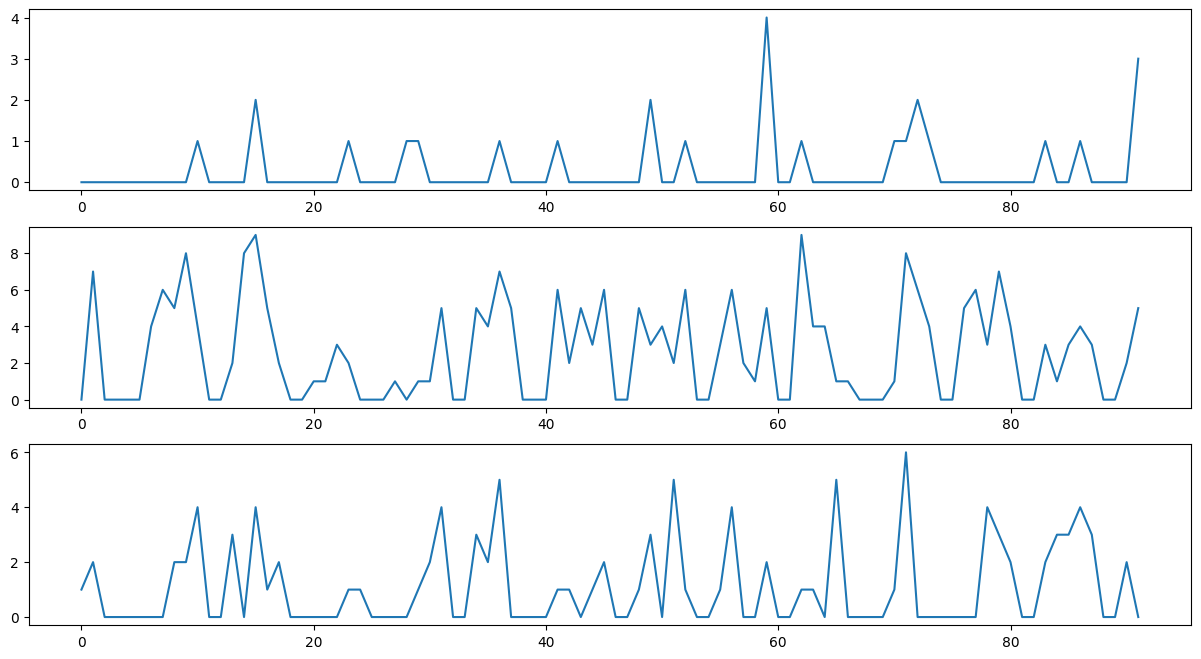

In [ ]:
amostra = random.sample(TODAS_324_ODS,3)

fig, ax = plt.subplots(nrows=3, figsize = (15,8))

for aaa in range(len(amostra)):
    ax[aaa].plot(amostra[aaa])

Isso aqui significa quais dias tem mais de 324 viagens atraves das entradas da OD 

Ou seja, como se tivesse pelo menos uma viagem para cada OD, de fato sao pouquissimos dias, so 4

In [ ]:

for i in range(92):

    if ODs_diarios[i].sum().sum() >=324:

        print(datetime(2021,6,1) + timedelta(days = i), '==================================================================')
        display(ODs_diarios[i])

2021-06-16 00:00:00 ==================================================================


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0.0,2.0,2.0,0.0,1.0,3.0,0.0,0.0,4.0,0.0,5.0,2.0,1.0,7.0,0,0.0,2.0,0.0
5,0.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,7.0,0.0,0,2.0,0.0,0.0
6,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,2.0,3.0,1.0
8,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0,0.0,0.0,0.0
9,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,3.0,1.0,0.0
10,1.0,4.0,1.0,0.0,1.0,0.0,6.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0,4.0,12.0,7.0
13,3.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0,1.0,3.0,7.0
15,0.0,1.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2.0,0.0,0.0
17,3.0,6.0,0.0,2.0,0.0,10.0,9.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0,1.0,4.0,7.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0


2021-07-27 00:00:00 ==================================================================


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0.0,3.0,2.0,0.0,4.0,7.0,0.0,1.0,3.0,1.0,3.0,2.0,0.0,5.0,0,2.0,1.0,0.0
5,0.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,12.0,1.0,0,4.0,0.0,0.0
6,0.0,7.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,5.0,0.0,1.0
8,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
9,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,4.0,0.0,2.0
10,1.0,4.0,2.0,1.0,1.0,1.0,8.0,0.0,9.0,2.0,0.0,0.0,0.0,1.0,0,1.0,9.0,12.0
13,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0,1.0,2.0,6.0
15,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,0.0,0.0
17,1.0,2.0,0.0,1.0,0.0,20.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0,1.0,2.0,7.0
18,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


2021-08-11 00:00:00 ==================================================================


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0.0,3.0,1.0,0.0,0.0,6.0,1.0,3.0,3.0,1.0,3.0,0.0,1.0,10.0,0,6.0,1.0,0.0
5,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,12.0,0.0,0,4.0,0.0,0.0
6,0.0,3.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,6.0,1.0,1.0
8,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0
9,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,0.0,0.0
10,4.0,6.0,2.0,0.0,1.0,0.0,7.0,0.0,10.0,2.0,1.0,1.0,0.0,3.0,0,5.0,13.0,4.0
13,0.0,1.0,0.0,1.0,0.0,6.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2.0,2.0
15,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,4.0,0.0,0.0
17,0.0,1.0,1.0,0.0,0.0,15.0,8.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0,1.0,5.0,6.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,2.0


2021-08-18 00:00:00 ==================================================================


,1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33
1,0.0,2.0,1.0,0.0,2.0,5.0,0.0,3.0,0.0,2.0,2.0,0.0,2.0,2.0,0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0,6.0,0.0,0.0
6,0.0,1.0,0.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0,1.0,2.0,0.0
8,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0,2.0,0.0,2.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0,4.0,0.0,0.0
10,2.0,4.0,2.0,2.0,1.0,0.0,8.0,0.0,16.0,0.0,1.0,0.0,1.0,2.0,0,2.0,14.0,9.0
13,0.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2.0,5.0
15,4.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
17,0.0,3.0,1.0,0.0,0.0,17.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0,6.0,2.0,7.0
18,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0


<BarContainer object of 92 artists>

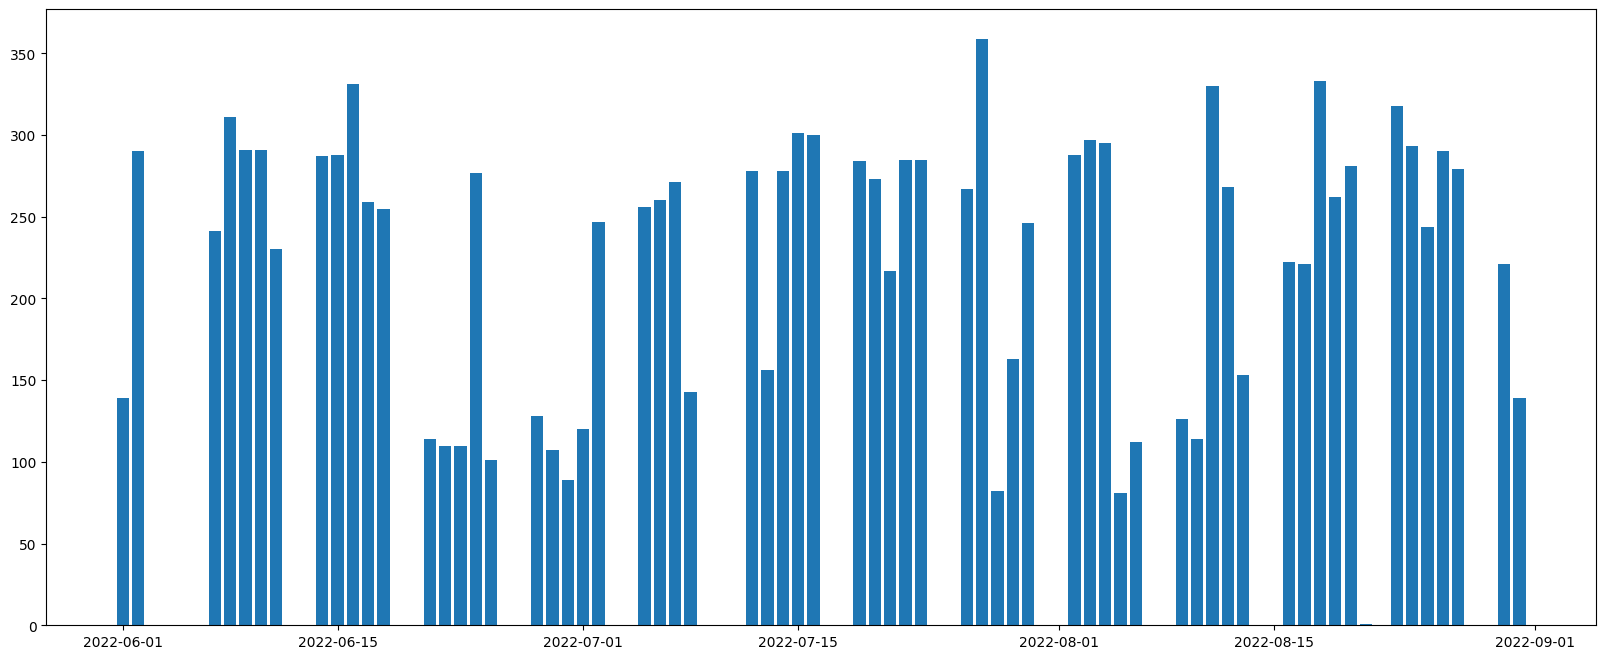

In [ ]:
# volumes_totais_diarios['Volume'].plot(kind='bar', figsize = (15,8));
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])